<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON_Trading_Strategy_Functions_v7_Markov_Probabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [215]:
!pip3 install pyfolio
!pip install datetime


# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [216]:
import os
import pandas_datareader.data as web
from datetime import datetime
from pprint import pprint
import pandas as pd

import datetime
import pyfolio as pyf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

current_date = datetime.datetime.now()

delta = 1
day = current_date.day
month = current_date.month
year = current_date.year - delta

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = False
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"

TR_Tickers = ["EREGL", "CANTE", "GARAN", "KCHOL", "EUPWR"]
US_Tickers = ["TSLA", "AAPL", "GOOGL", "BA", "V"]
DOW30 = ["AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","JNJ","KO","JPM",
         "MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM","VZ","V","WBA","WMT","DIS","DOW"]

BIST30 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK"]

BIST100 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","K DMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK",
          "AEFES","AGHOL","AHGAZ","AKCNS","AKFGY","AKSA","AKSEN",
           "ALBRK","ASUZU","AYDEM","BAGFS","BERA",
           "BRSAN","BRYAT","BUCIM","CANTE","CCOLA","CEMTS","CIMSA",
           "DOAS","DOHOL","ECILC","ECZYT","EGEEN","ENJSA",
           "GENIL","GESAN","GLYHO","GSDHO","GWIND","HALKB","IPEKE",
           "ISDMR","ISGYO","ISMEN","IZMDC","KARSN","KMPUR",
           "KONTR","KONYA","KORDS","KZBGY","MAVI","OTKAR","OYAKC",
           "PENTA","PETKM","QUAGR","SELEC","SKBNK","SMRTG",
           "SNGYO","SOKM","TAVHL","TKFEN","TKNSA","TOASO","TSKB",
           "TTKOM","TTRAK","TUKAS","ULKER","VAKBN","VESBE","ZOREN"]


sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

sp500_constituents = pd.read_html(sp_url, header=0)[0]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BRK.B"]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BF.B"]

sp500_constituents.Symbol



0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 501, dtype: object

In [217]:
def ConvertToUSD(ticker, start, end, exchange):

    adjclose = yf.download(ticker,start,end)['Adj Close']
    close = yf.download(ticker,start,end)['Close']
    open = yf.download(ticker,start,end)['Open']

    adjusted_factor = adjclose / close
    adjopen = adjusted_factor * open

    usdtry = yf.download('TRY=X',start,end)['Adj Close']

    if ( exchange != "SP500" or exchange != "DOW30"):
      for i in np.arange(0,len(close)):
          adjclose[i] = close[i]/usdtry[i]
          adjopen[i] = open[i]/usdtry[i]

    rets = adjclose.pct_change()

    return adjclose, adjopen, rets

In [218]:
def UpdateData(TickerIS, START, END, exchange):

  # For data manupulations

  # VF    LB    PEAK_CUM  CUM_LAST    REVERSED
  # 0.25  45    6.11       4.29 OK    True
  # 0.35  45    7.42       5.02 OK    True
  # 0.40  45    7.64       5.17 OK    True
  # 0.45  45    8.99       6.16 OK    True
  # 0.45  45    1.22       1.05 OK    False
  # 0.45  55    7.97       5.39 OK    True
  # 0.45  40    9.35       6.31 OK    True
  # 0.45  35    9.65       7.14 OK    True
  # 0.45  33    9.78       7.24 OK    True  ***
  # 0.45  32    10.02      7.42 OK    True  ****
  # 0.45  30    9.16       6.78 OK    True
  # 0.45  25    8.19       5.98 OK    True
  # -   -       5.17       4.82 OK    True / original Gap up buy side.

  # Read data from Yahoo finance

  data = yf.download(TickerIS,START, END)
  # Convert index into datetime format
  data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
  # Calculate adjustment factor

  if ( exchange != "SP500" or exchange != "DOW30"):
    # In Turkish exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "BIST")
  else:
    # In US exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "DOW30")

  data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)
  data['std'] = data['returns'].rolling(R_WINDOW).std()
  data['positions'] = np.nan
  data['close']= data['Adj Close']
  data["log_returns"] = data['close'].pct_change().apply(lambda x: np.log(1+x))
  data["rel"]= data['Adj Close'] / data['Adj Close'][0]

  # Long entry condition
  if REVERSED:
      long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
      long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']

  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  data['cumulative_normal_returns'] = (data.returns+1).cumprod()
  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()

    # In US exchange
    # data['close=usd'], data['open=usd'], data['rets=usd'] = ConvertToUSD(TickerIS, START, END, "SP500")
    # data['open=usd=adj'] = adjusted_factor * data['open=usd']
    # data['rets=usd'] = (data['open=usd=adj'] - data['close=usd'].shift(1)) / data['close=usd'].shift(1)
    # data['std=usd'] = data['rets=usd'].rolling(R_WINDOW).std()
    # data["log_returns=usd"] = data['close=usd'].pct_change().apply(lambda x: np.log(1+x))
    # data["rel=usd"]= data['close=usd'] / data['close=usd'][0]
    #  # Long entry condition
    # if REVERSED:
    #   long_entry_usd = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
    #   short_entry_usd = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
    # else:
    # # Short entry condition
    #   long_entry_usd = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
    #   short_entry_usd = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
    # # Store 1 when long entry condition is true
    #   data.loc[long_entry_usd, 'positions_usd'] = 1
    #   data.loc[short_entry_usd, 'positions_usd'] = 0
    #   data['positions_usd'].fillna(method='ffill', inplace=True)
    #   data['strategy_returns=usd'] = ((data['close=usd'] - data['open=usd=adj']) / data['open=usd=adj']) * data.positions_usd
    #   data['cumulative_normal_returns=usd'] = (data['rets=usd']+1).cumprod()
    #   data['cumulative_strategy_returns=usd'] = (data['strategy_returns=usd']+1).cumprod()

  return data

In [219]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [220]:
# IMPROVED STRATEGY
def Strategy(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  # data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  return data



In [221]:
# IMPROVED STRATEGY
def Volatility_Strategy_USD_TR(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)


  return data



In [222]:


# Drop NaN values
#data = data.dropna()

In [223]:
def CalculateStrReturns(data):
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  return data

In [224]:
def PlotUSDTROpenClosePerformance(Ticker,data):
  print(f"Plotting Open-Close Performance for {Ticker}")
  # Plot cumulative returns
  global LEFT, RIGHT
  import datetime

  fig = plt.gcf()
  fig.set_size_inches(16, 22)

  # ----------------------------------------------------------------------------------
  plt.subplot(3, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} USD price", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Price USD', fontsize=12)

   # ----------------------------------------------------------------------------------
  plt.subplot(3, 1, 2)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['cumulative_normal_returns'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} data['cumulative_normal_returns'] ", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Open-Close Trade Returns', fontsize=12)


  # ----------------------------------------------------------------------------------
  plt.subplot(3, 1, 3)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['cumulative_strategy_returns'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} data['cumulative_strategy_returns'] ", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Volatility Strategy Returns', fontsize=12)

 #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 3)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['close'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL price", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Price TL', fontsize=12)

  # #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 4)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['cumulative_normal_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL Open-Close Strategy", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Open-Close Strategy TL Returns', fontsize=12)

  # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 4)
  # plt.xlim(LEFT, RIGHT)
  # plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  # plt.xlabel('Date', fontsize=14)
  # plt.ylabel(f'{Ticker} volatility', fontsize=14)
  # plt.grid()
  # plt.xticks(fontsize=12)

  # plt.plot(data['std=usd']*252**0.5)

  plt.show()

In [225]:
def ShowDataTable(data):
  global year, day, month
  return(data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna())




In [226]:


def CreateTearSheetForData(data):
  # if we buy and hold performance would be:
  print("\nIf we buy and hold performance would be:")
  print("\n======================================")
  pyf.create_simple_tear_sheet(data['rets'])

  # if we apply open-close strategy, performance would be:
  print("\nIf we apply open-close strategy, performance would be:")
  print("\n====================================================")
  pyf.create_simple_tear_sheet(data['returns'])


In [227]:
def EvaluateFeasibility(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return feasible

In [228]:
def EvaluateFeasibility_TR(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible

In [229]:
def EvaluateFeasibility_USD(data):
  Max_Cum_Norm_Ret = np.max(data['cumulative_normal_returns'])
  Max_Cum_Str_Ret = np.max(data['cumulative_strategy_returns'])

  Last_Cum_Norm_Ret = data['cumulative_normal_returns'][-1]
  Last_Cum_Str_Ret = data['cumulative_strategy_returns'][-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data['cumulative_normal_returns'][-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible


In [230]:
def ShowTRMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:
    ticker = ticker + ".IS"
    d = UpdateData(ticker, START, END, "BIST")
    #d = Volatility_Strategy_USD_TR(d)
    opc,clo,fb = EvaluateFeasibility_USD(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df



In [231]:
def ShowUSMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:
    print(f"Downloading {ticker}...")
    d = UpdateData(ticker, START, END, "DOW30")
    #d = Volatility_Strategy_USD_TR(d)
    opc,clo,fb = EvaluateFeasibility_TR(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df


In [232]:
def ShowTickerStats(ticker, exchange):

  print("\n====================================================")
  print(f"\nUpdating data for {ticker}")
  print("\n====================================================")
  d = UpdateData(ticker, START, END, exchange)

  print("\n====================================================")
  print(f"\nPlotting for {ticker}")
  print("\n====================================================")
  PlotUSDTROpenClosePerformance(ticker, d)

  print("\n====================================================")
  print(f"Creating Tear Sheet for {ticker}")
  print("\n====================================================")
  CreateTearSheetForData(d)

  print("\n====================================================")
  print(f"Next State Probabilities for {ticker} Buy-Hold")
  print("\n====================================================")
  PredictNextState(d['rets'])

  print("\n====================================================")
  print(f"Next State Probabilities for {ticker} Open-Close")
  print("\n====================================================")
  PredictNextState(d['returns'])

  return d

In [233]:
def EmpyrialPortfolioPerformance():
  !pip install Scikit-learn
  !pip install empyrial

  from empyrial import empyrial, Engine

  pf2 = Engine(
                    start_date= START, #start date for the backtesting
                    portfolio = ["ODAS.IS", "ALARK.IS", "KOZAA.IS", "ENKAI.IS","KRDMD.IS", "ISCTR.IS", "PETKM.IS", "TAVHL.IS", "EREGL.IS"],
                    optimizer = "MEANVAR", # defines Mean-Variance as the optimizer
                    max_vol = 40, #maximize the return for this level of volatility (25%)
                    benchmark = ["TRY=X"], #NIFTY50 is set by default
                    #rebalance = "1Y" #rebalance every year
                    #risk_manager = {"Take Profit" : 1} #Stop the investment when the profit becomes superior to 25%
  )
  empyrial(pf2)
  empyrial.orderbook


In [234]:
def PredictNextState(datareturns):
    state_bins = [-np.inf, 0, np.inf]
    datastate = pd.cut(datareturns, bins=state_bins)
    # Calculate the transition matrix
    transition_matrix = pd.crosstab(datastate, datastate.shift(-1), normalize='index')
    # Print the transition matrix
    #print(transition_matrix)
    current_state = datastate.iloc[-1]
    #next_state = np.random.choice(transition_matrix.columns, p=transition_matrix.loc[current_state].values)
    next_state = transition_matrix.loc[current_state].idxmax()
    #print(f'Predicted next state: {next_state}')
    # Print the probabilities of all states
    state_probabilities = datastate.value_counts(normalize=True)
    print("State probabilities:")
    print(state_probabilities)

    return next_state


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

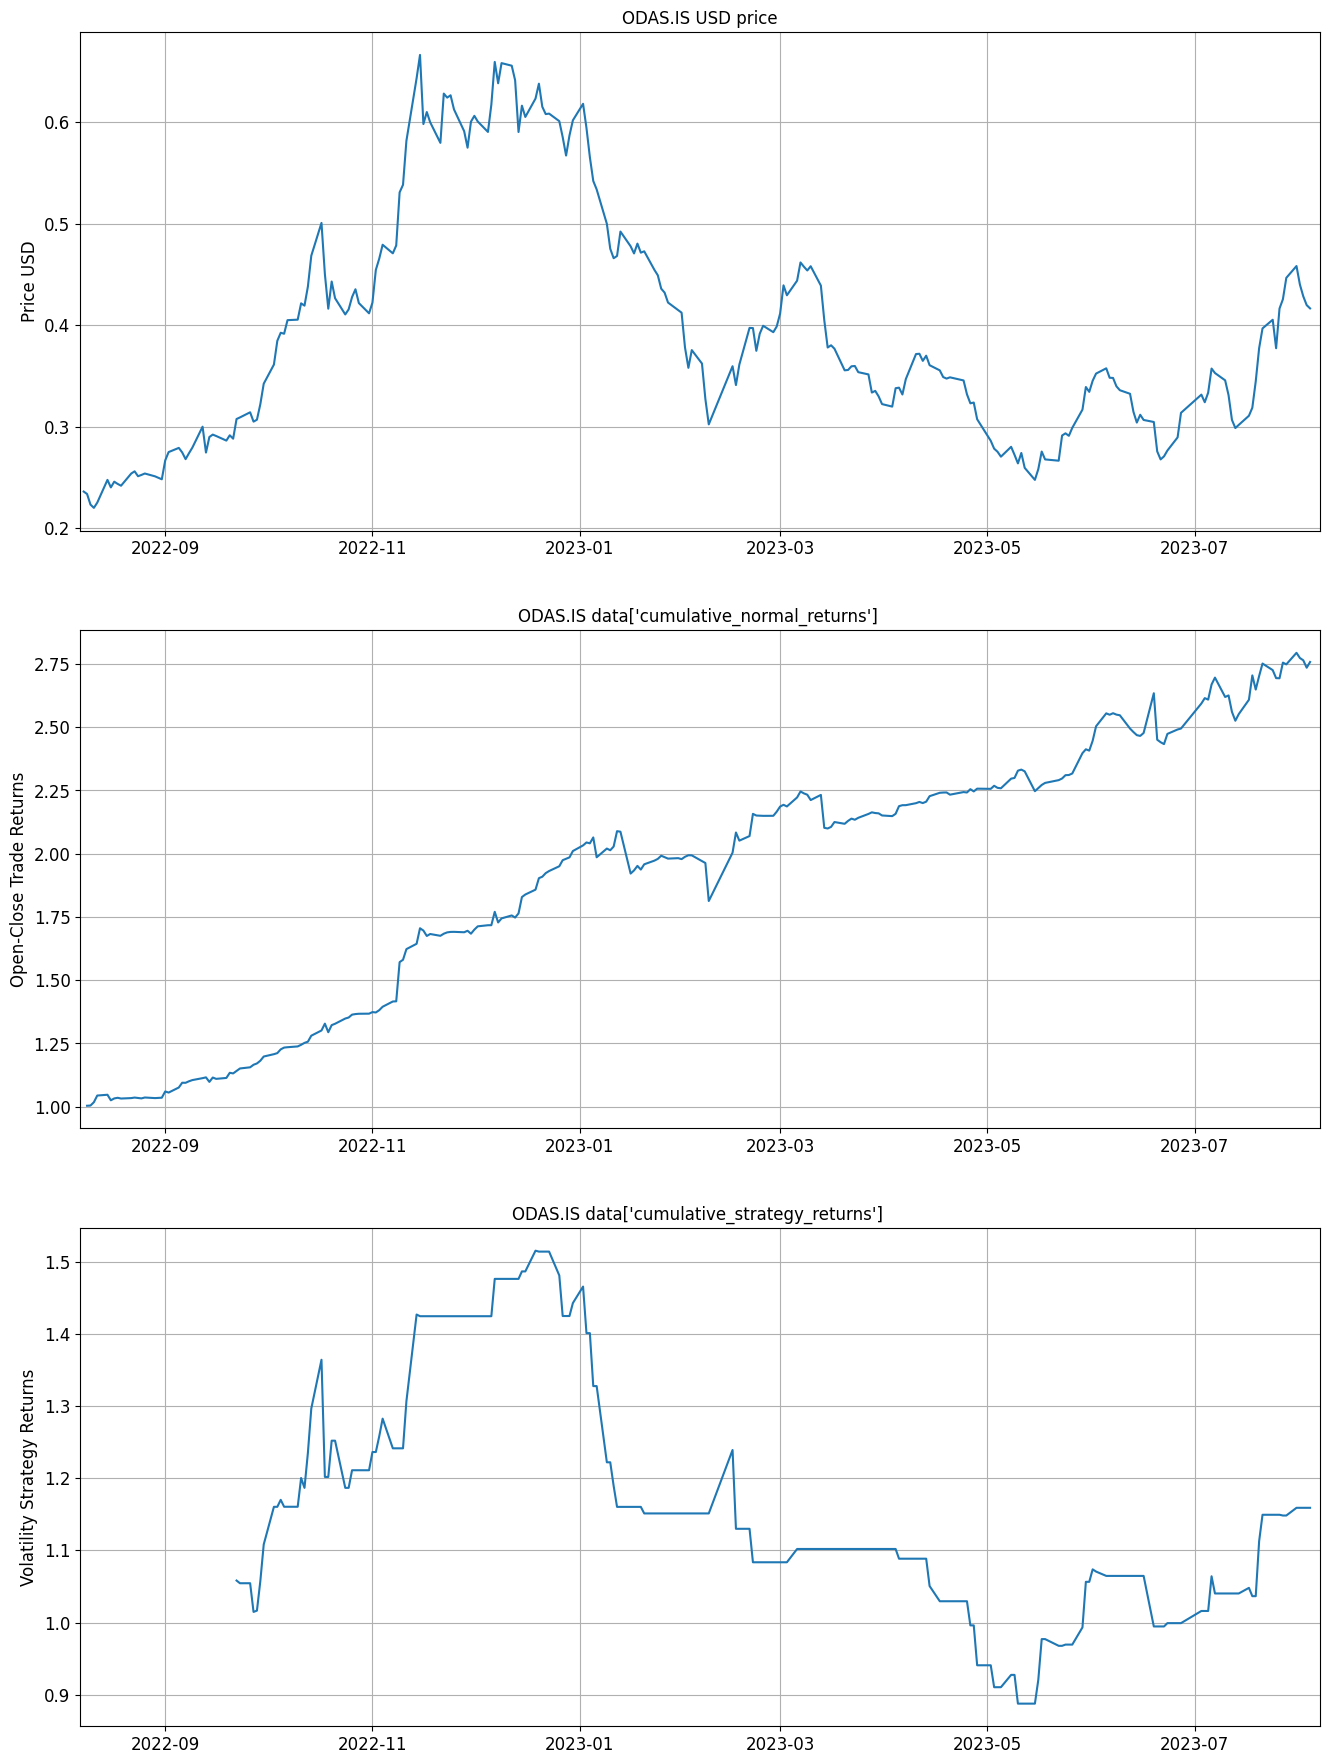


Creating Tear Sheet for ODAS.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for ODAS.IS Buy-Hold

State probabilities:
(-inf, 0.0]    0.516129
(0.0, inf]     0.483871
Name: rets, dtype: float64

Next State Probabilities for ODAS.IS Open-Close

State probabilities:
(0.0, inf]     0.677419
(-inf, 0.0]    0.322581
Name: returns, dtype: float64


Showing Ticker Stats for ALARK.IS : 



Updating data for ALARK.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ALARK.IS

Plotting Open-Close Performance for ALARK.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


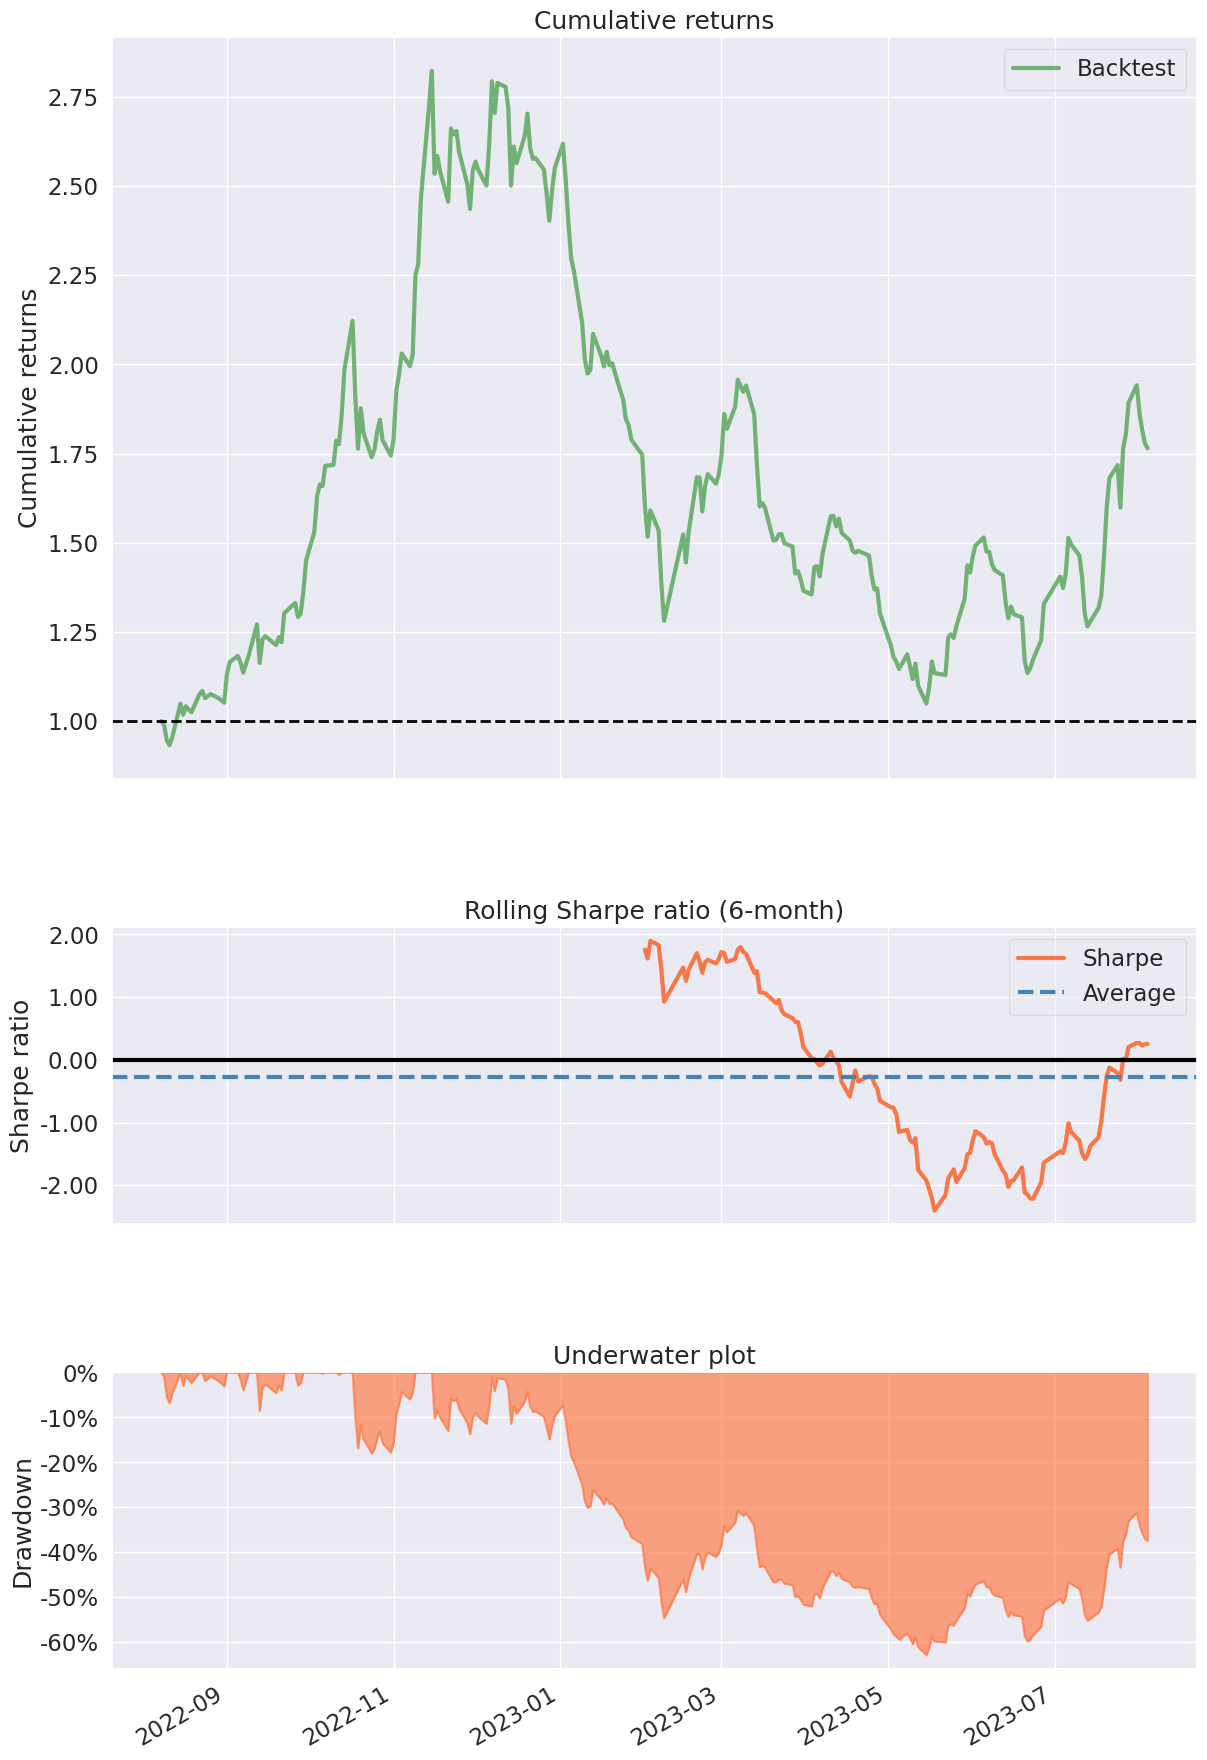

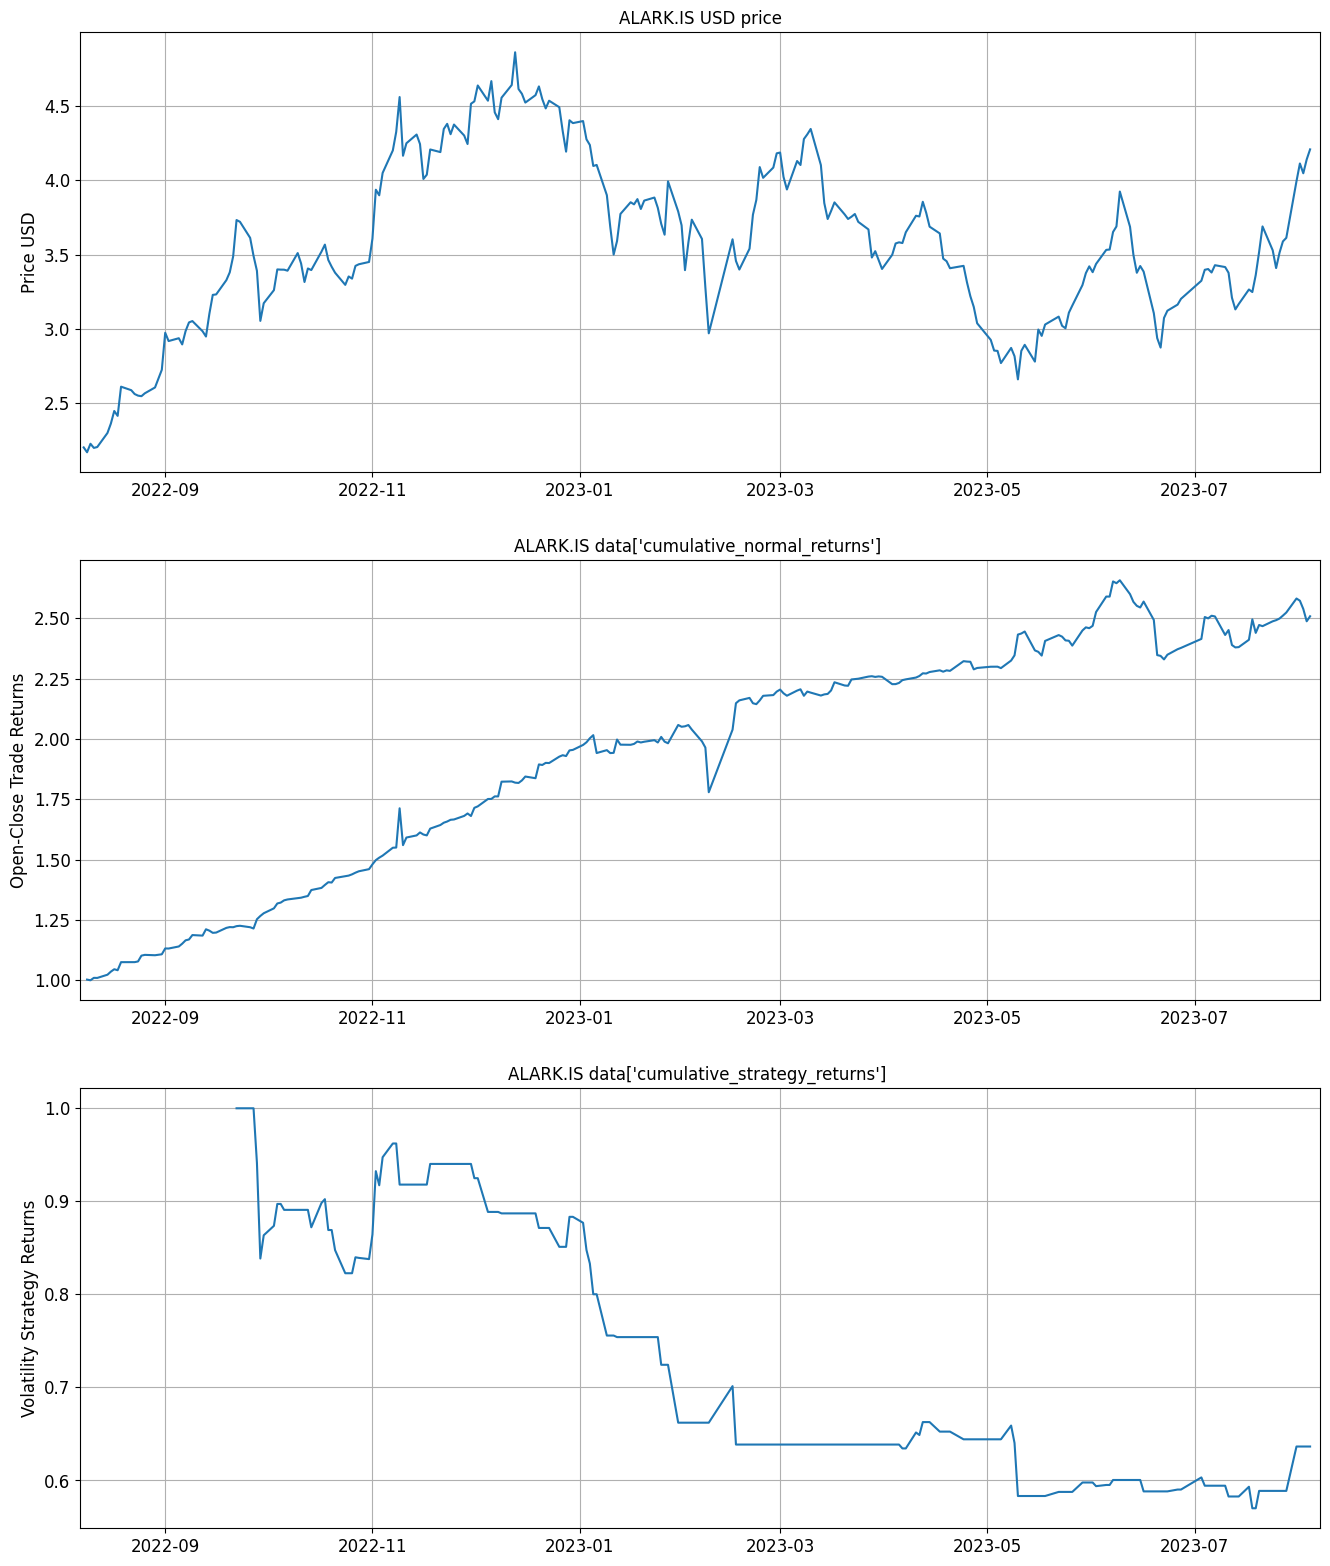


Creating Tear Sheet for ALARK.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for ALARK.IS Buy-Hold

State probabilities:
(0.0, inf]     0.520161
(-inf, 0.0]    0.479839
Name: rets, dtype: float64

Next State Probabilities for ALARK.IS Open-Close

State probabilities:
(0.0, inf]     0.657258
(-inf, 0.0]    0.342742
Name: returns, dtype: float64


Showing Ticker Stats for KOZAA.IS : 



Updating data for KOZAA.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for KOZAA.IS

Plotting Open-Close Performance for KOZAA.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


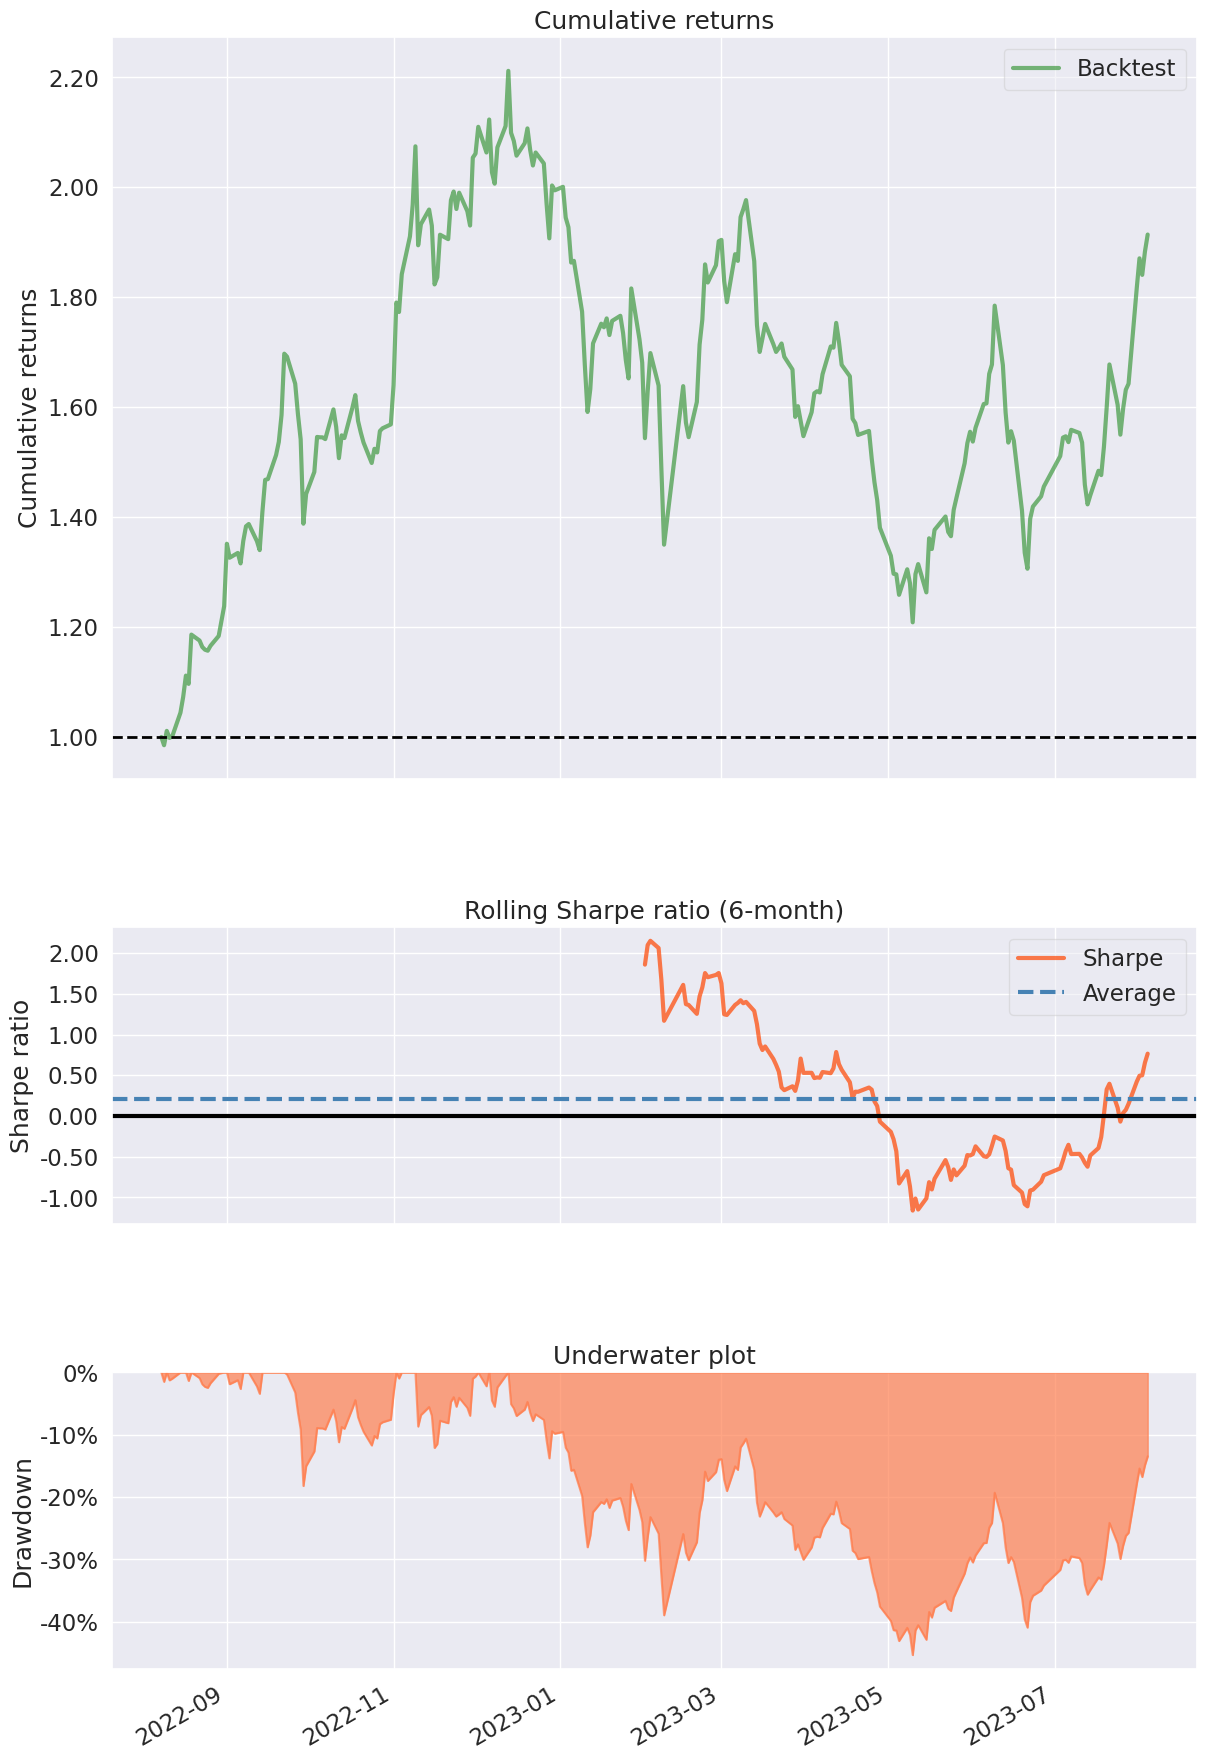

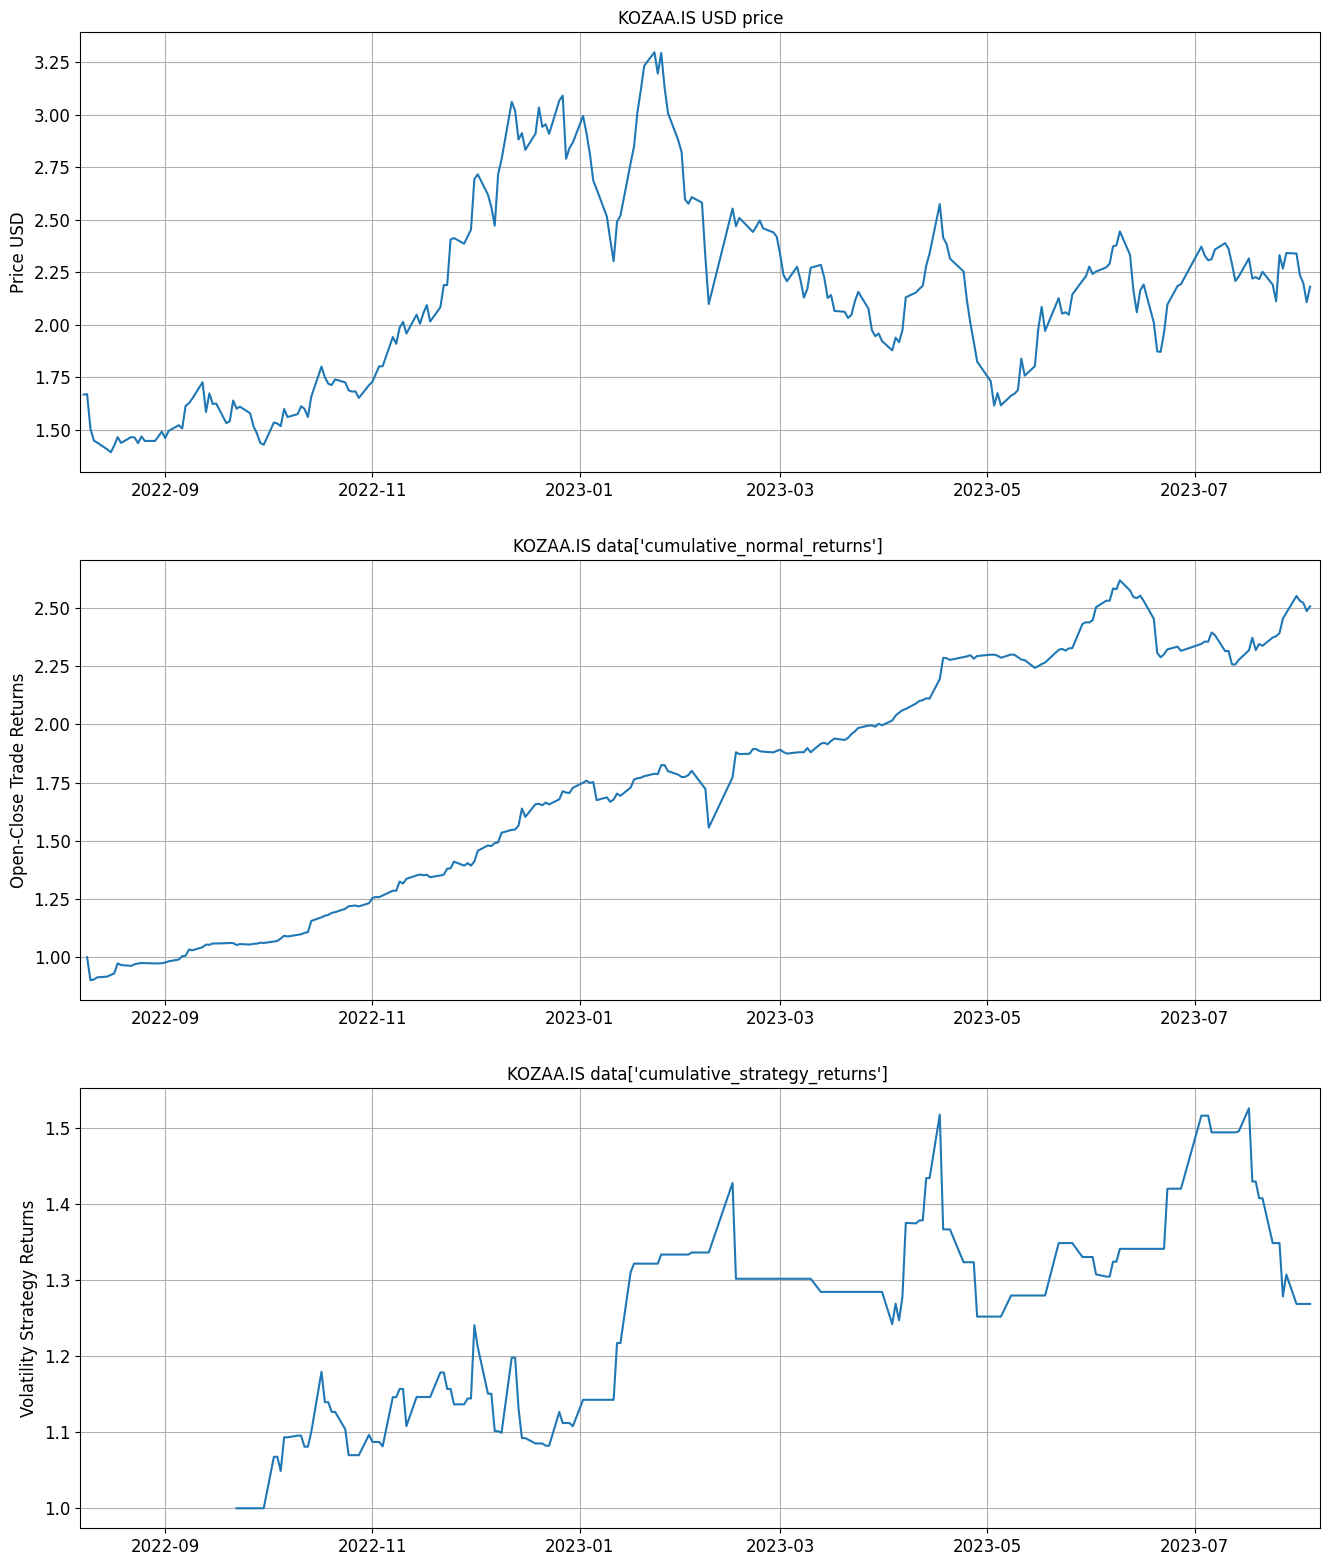


Creating Tear Sheet for KOZAA.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for KOZAA.IS Buy-Hold

State probabilities:
(0.0, inf]     0.508065
(-inf, 0.0]    0.491935
Name: rets, dtype: float64

Next State Probabilities for KOZAA.IS Open-Close

State probabilities:
(0.0, inf]     0.665323
(-inf, 0.0]    0.334677
Name: returns, dtype: float64


Showing Ticker Stats for ENKAI.IS : 



Updating data for ENKAI.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ENKAI.IS

Plotting Open-Close Performance for ENKAI.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


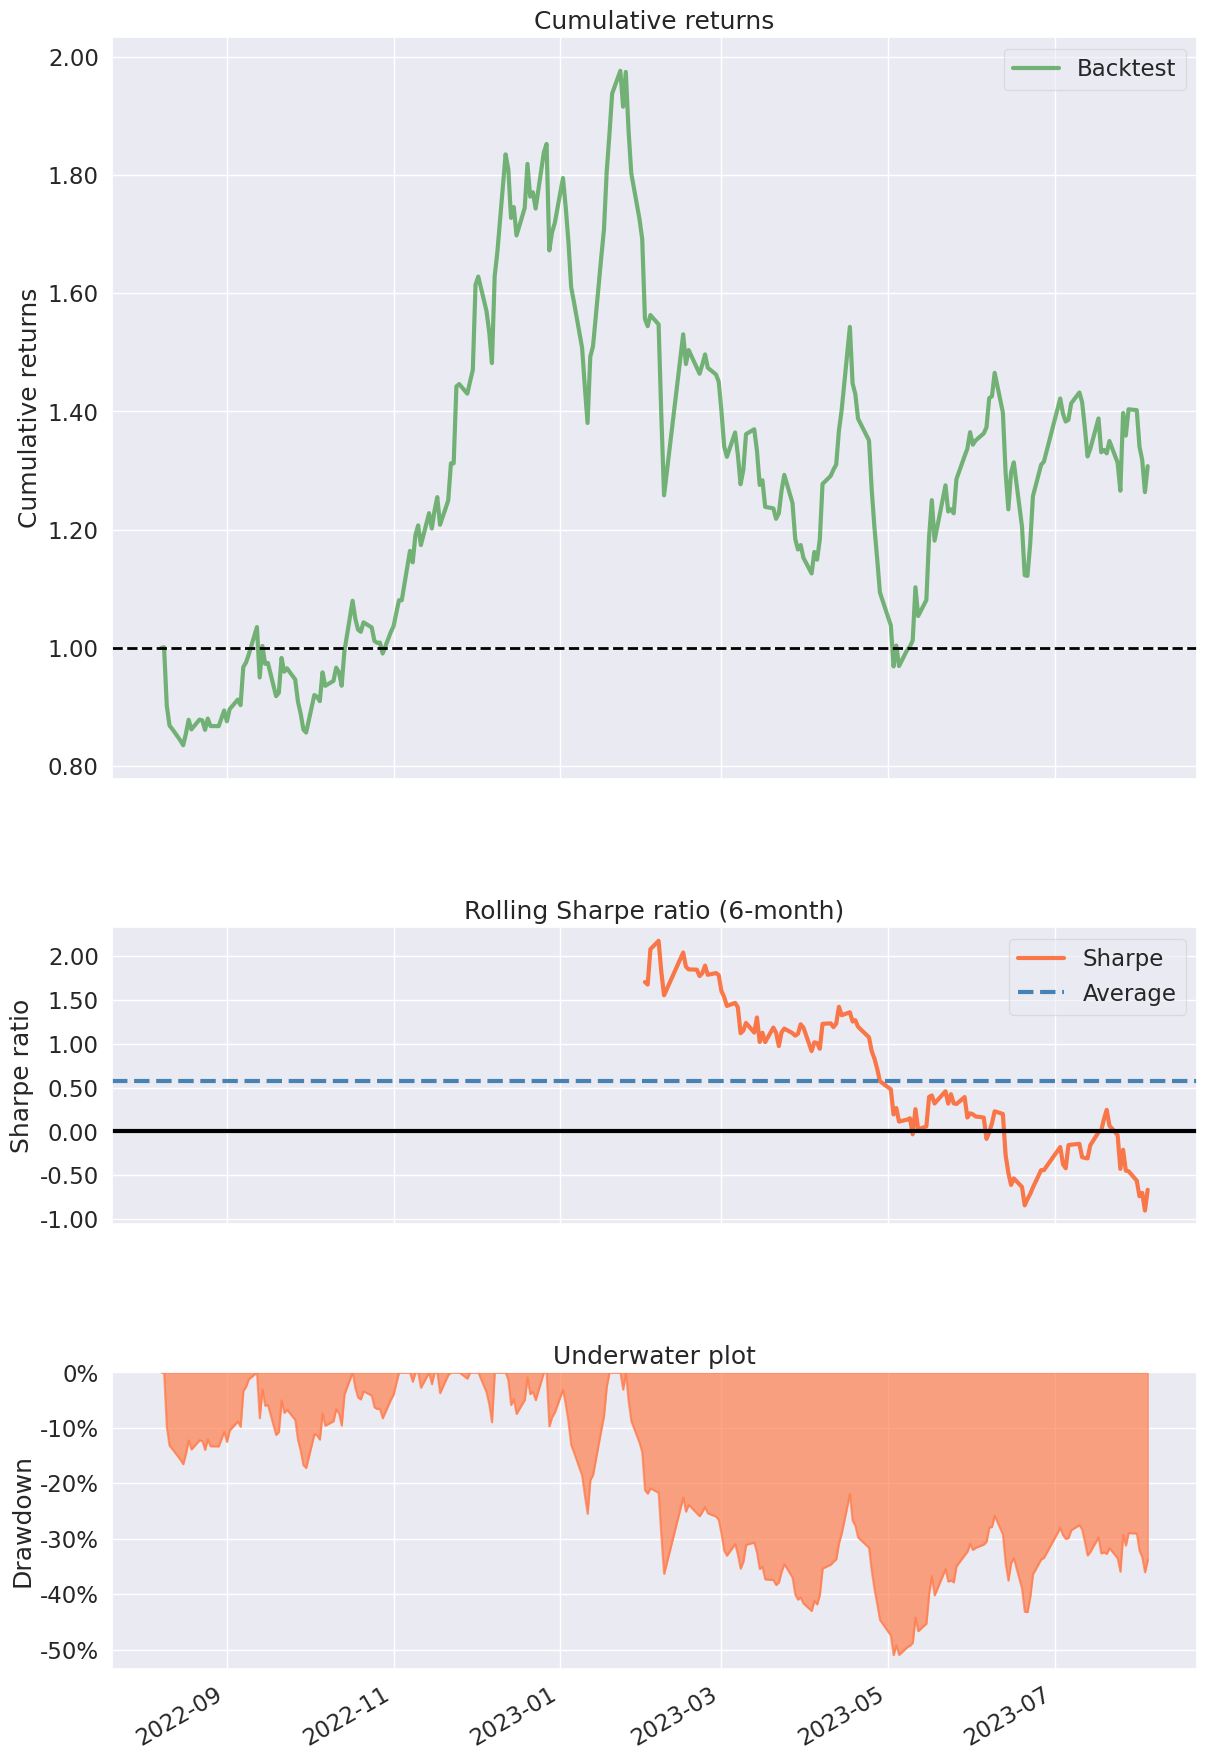

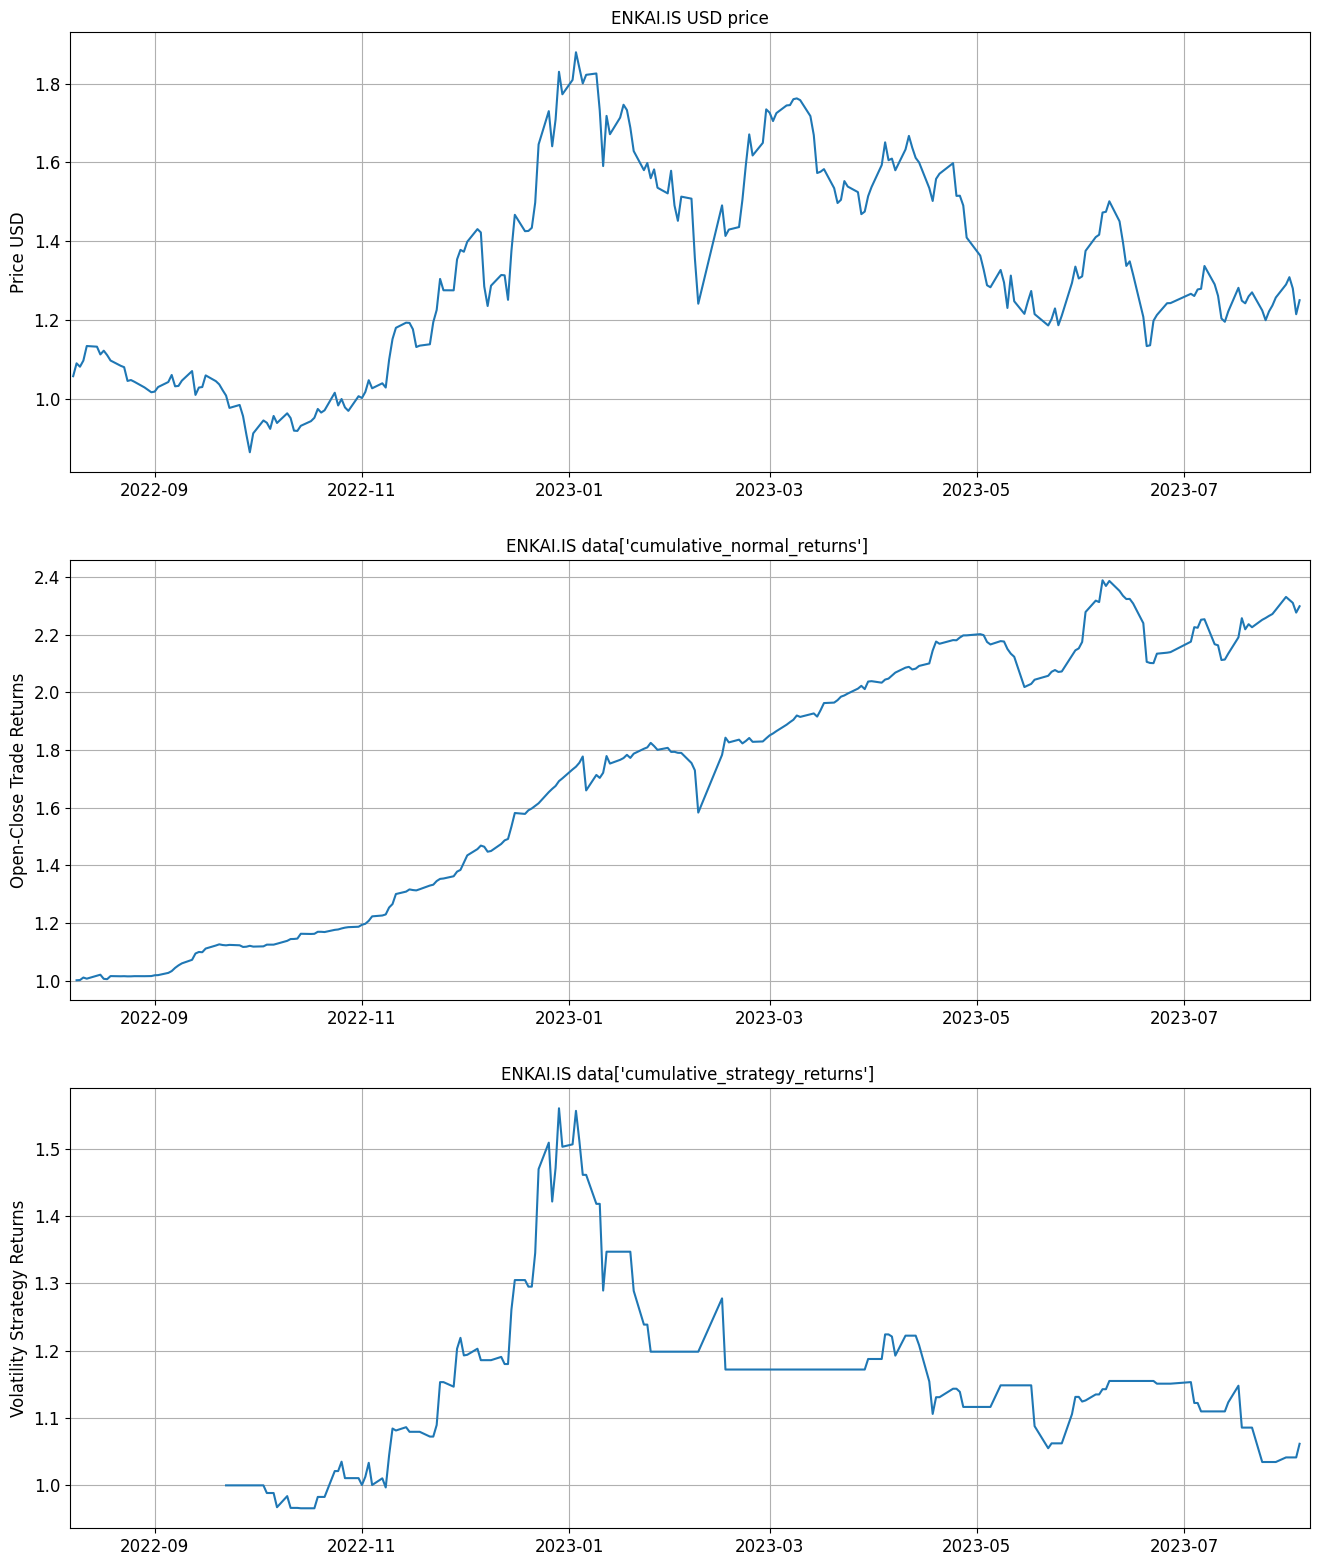


Creating Tear Sheet for ENKAI.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for ENKAI.IS Buy-Hold

State probabilities:
(0.0, inf]     0.528226
(-inf, 0.0]    0.471774
Name: rets, dtype: float64

Next State Probabilities for ENKAI.IS Open-Close

State probabilities:
(0.0, inf]     0.71371
(-inf, 0.0]    0.28629
Name: returns, dtype: float64


Showing Ticker Stats for KRDMD.IS : 



Updating data for KRDMD.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for KRDMD.IS

Plotting Open-Close Performance for KRDMD.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


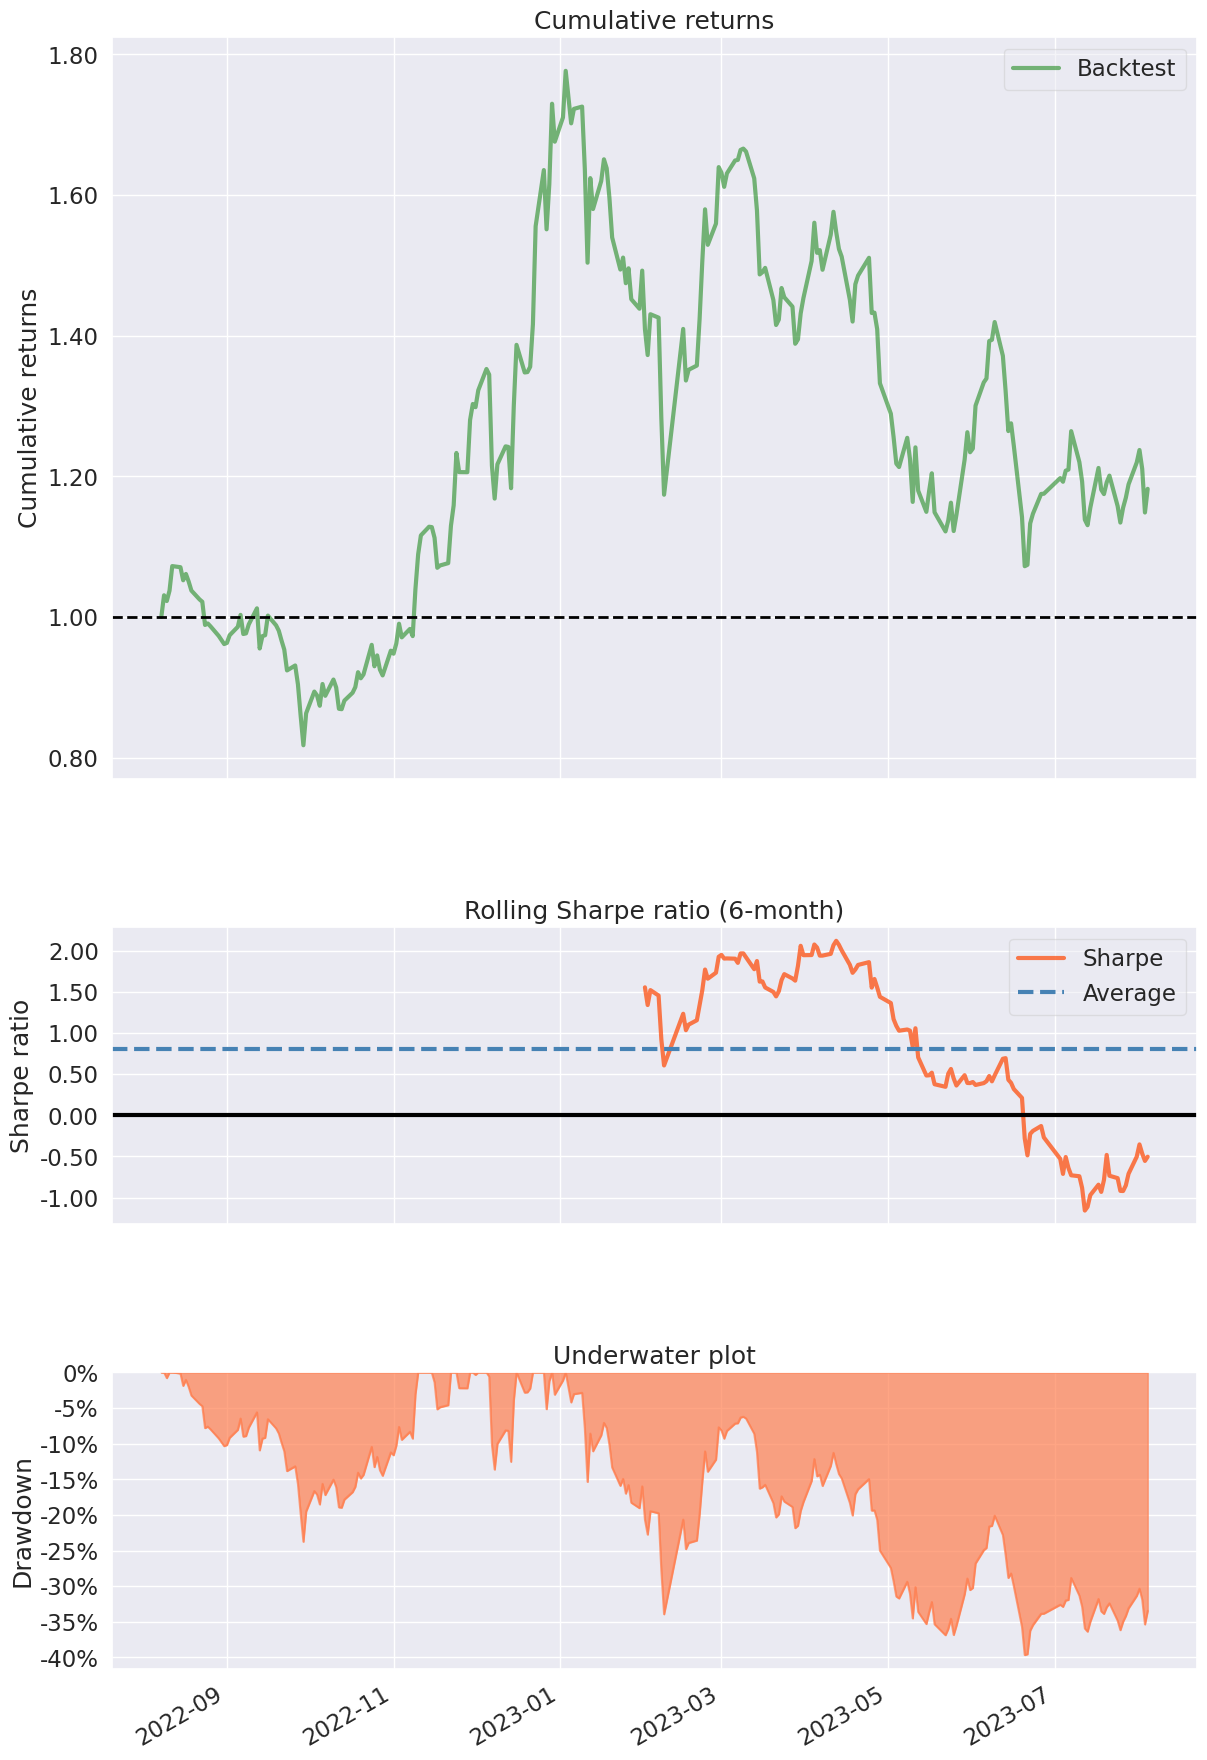

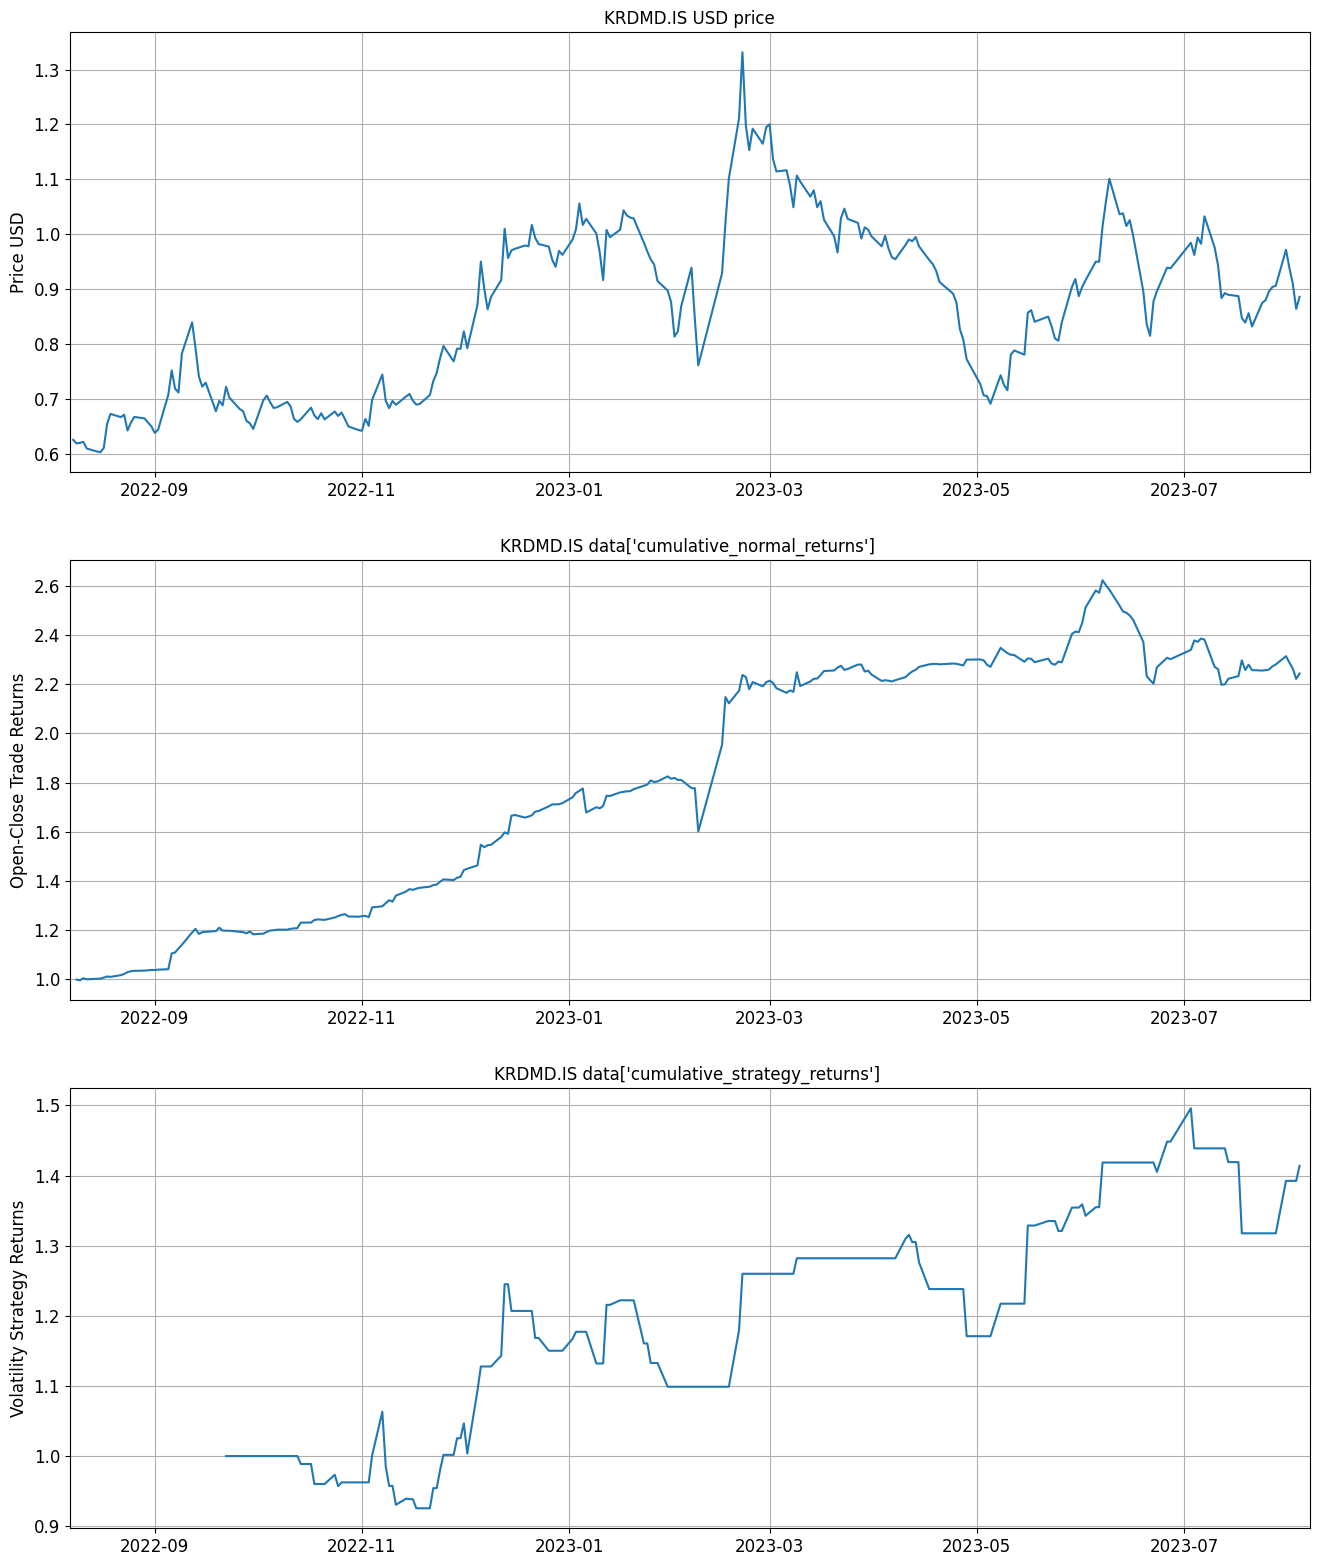


Creating Tear Sheet for KRDMD.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for KRDMD.IS Buy-Hold

State probabilities:
(-inf, 0.0]    0.556452
(0.0, inf]     0.443548
Name: rets, dtype: float64

Next State Probabilities for KRDMD.IS Open-Close

State probabilities:
(0.0, inf]     0.625
(-inf, 0.0]    0.375
Name: returns, dtype: float64


Showing Ticker Stats for ISCTR.IS : 



Updating data for ISCTR.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for ISCTR.IS

Plotting Open-Close Performance for ISCTR.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


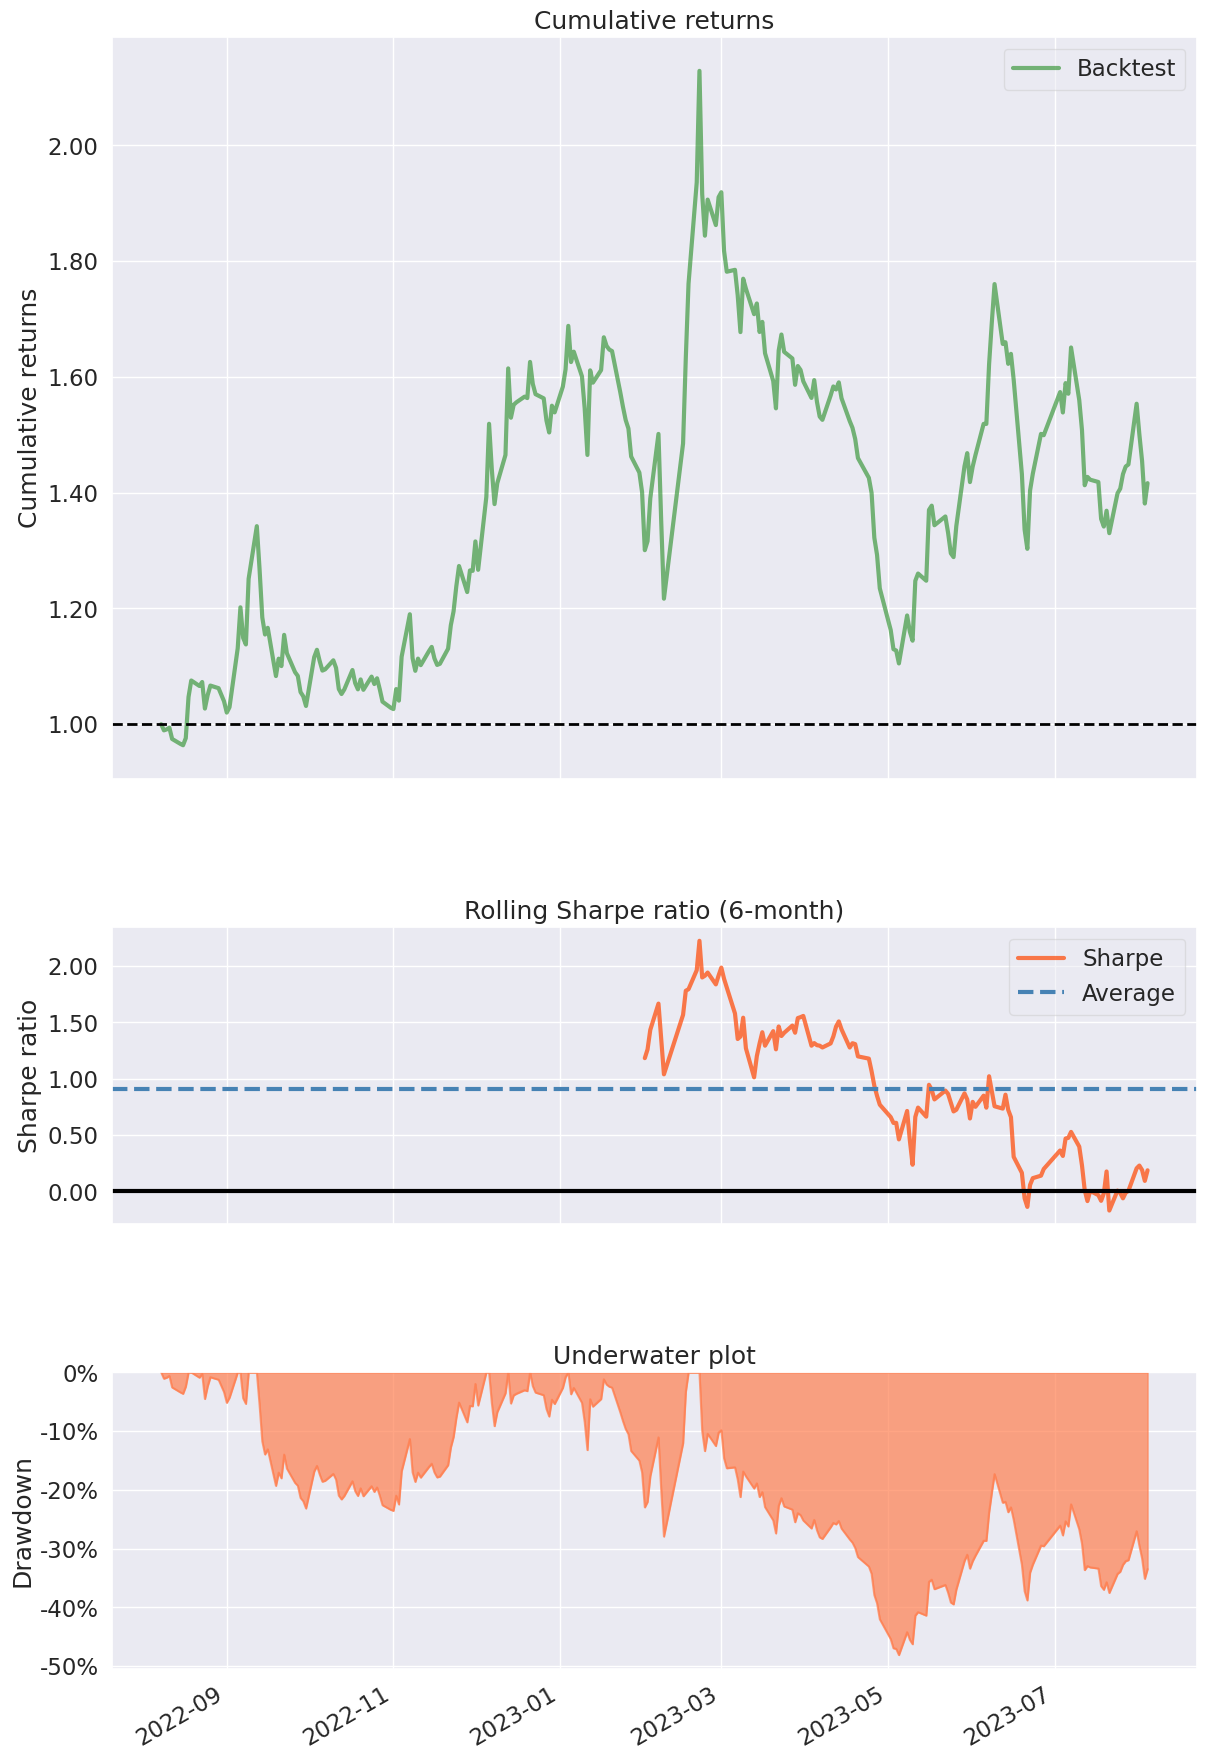

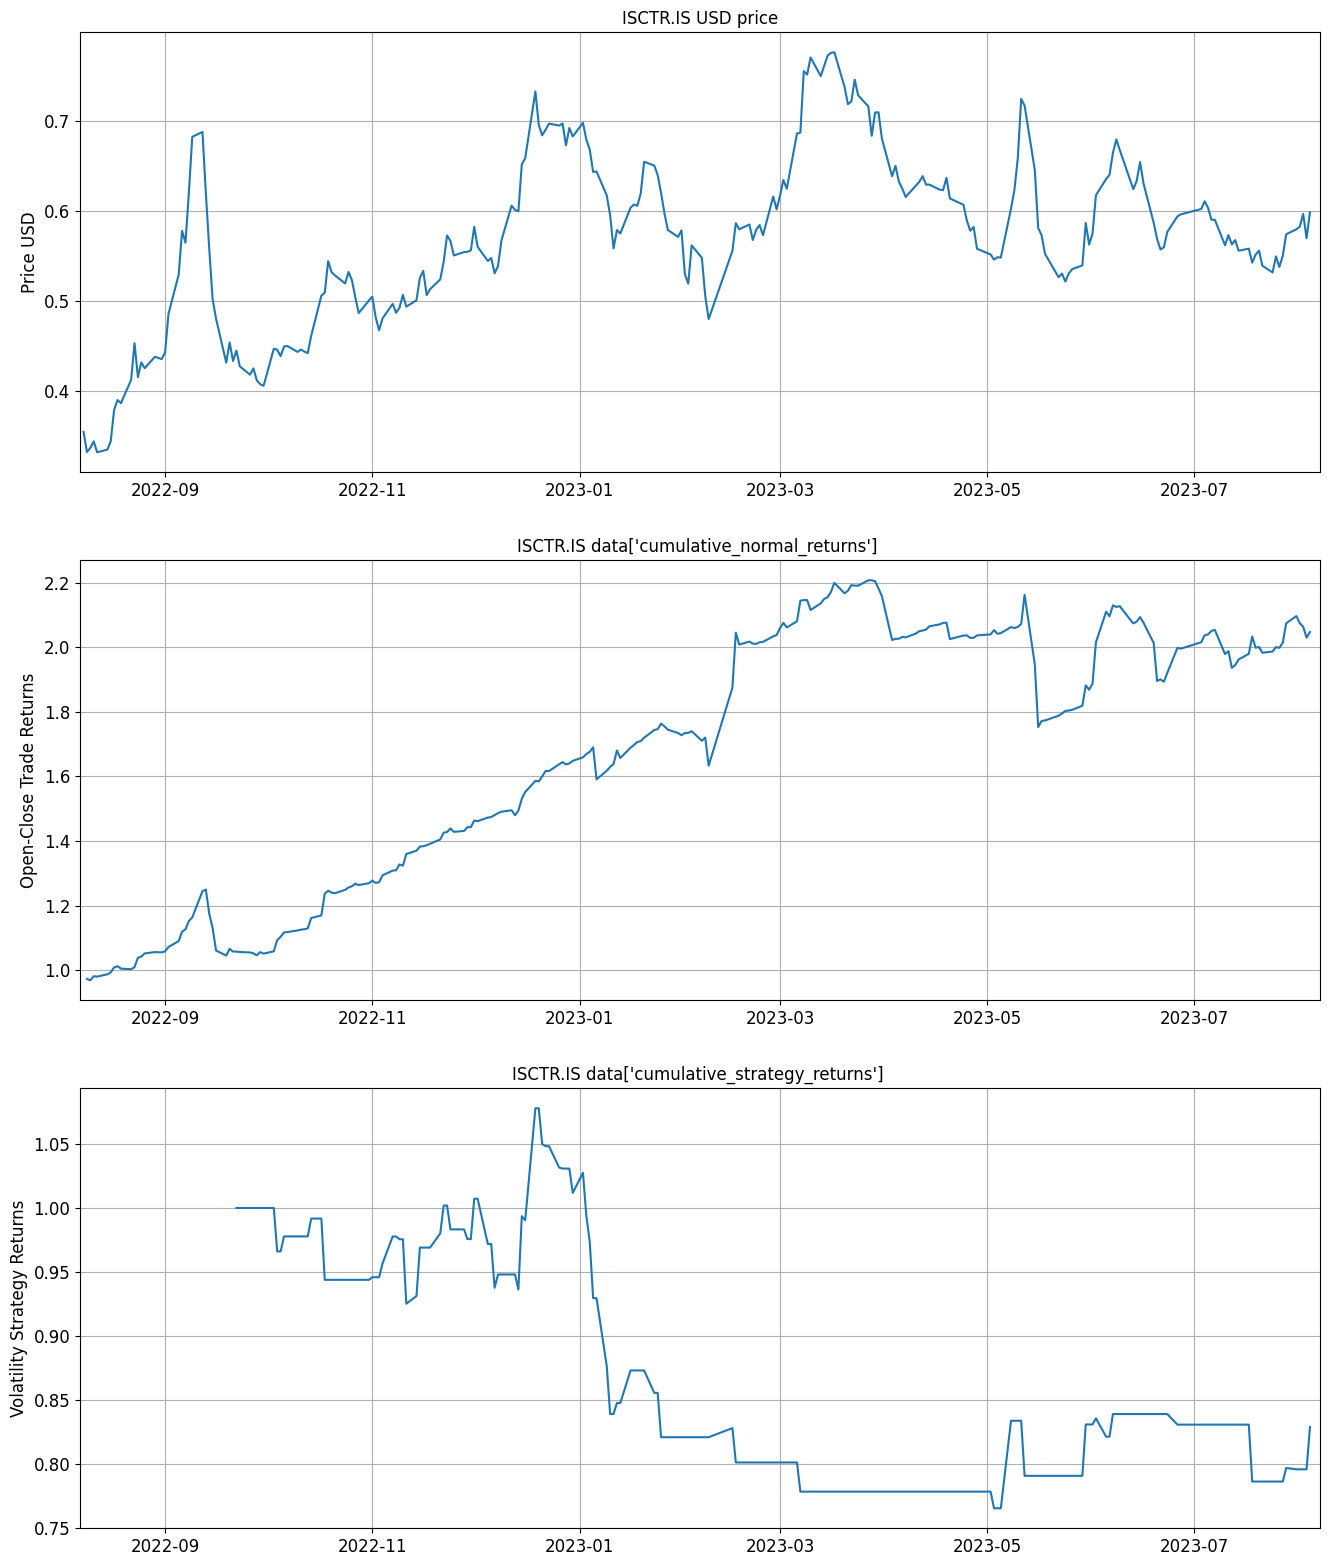


Creating Tear Sheet for ISCTR.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for ISCTR.IS Buy-Hold

State probabilities:
(0.0, inf]     0.520161
(-inf, 0.0]    0.479839
Name: rets, dtype: float64

Next State Probabilities for ISCTR.IS Open-Close

State probabilities:
(0.0, inf]     0.697581
(-inf, 0.0]    0.302419
Name: returns, dtype: float64


Showing Ticker Stats for PETKM.IS : 



Updating data for PETKM.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for PETKM.IS

Plotting Open-Close Performance for PETKM.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


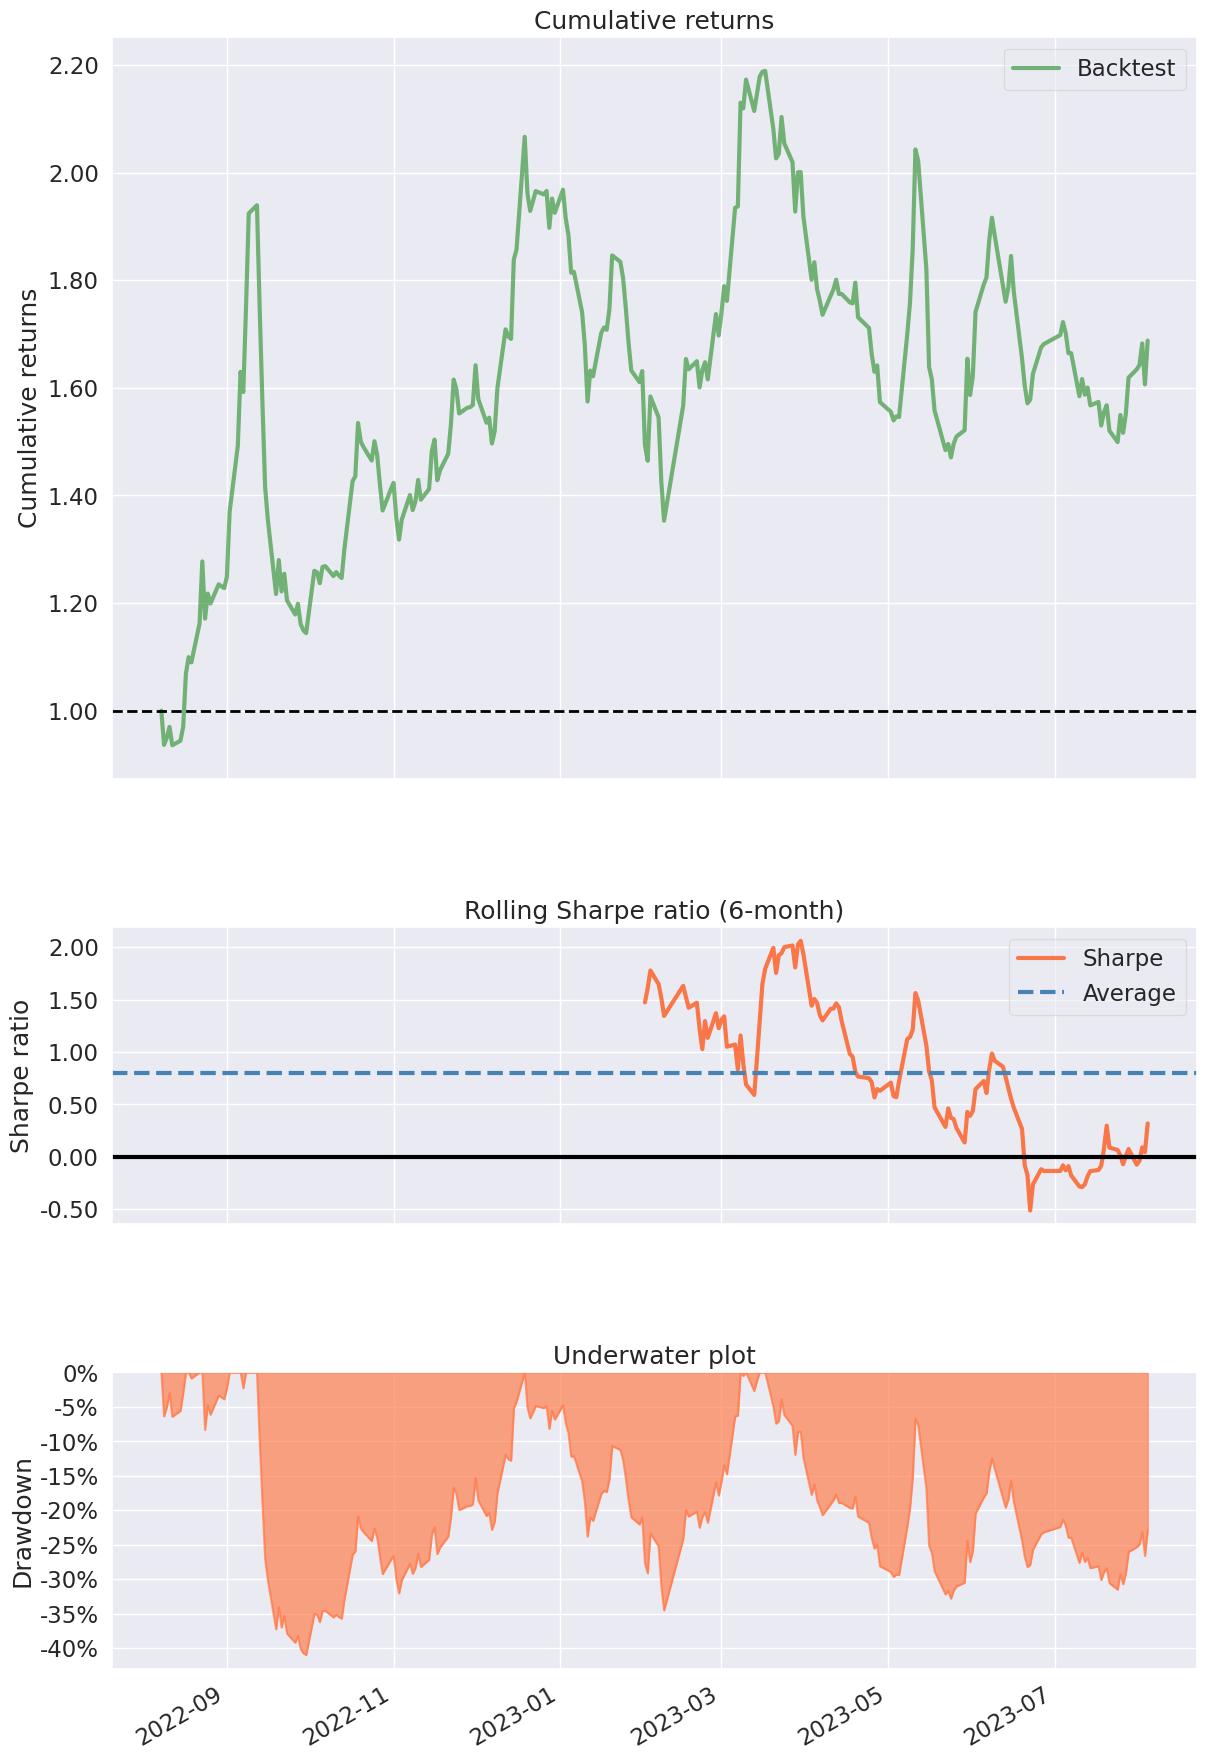

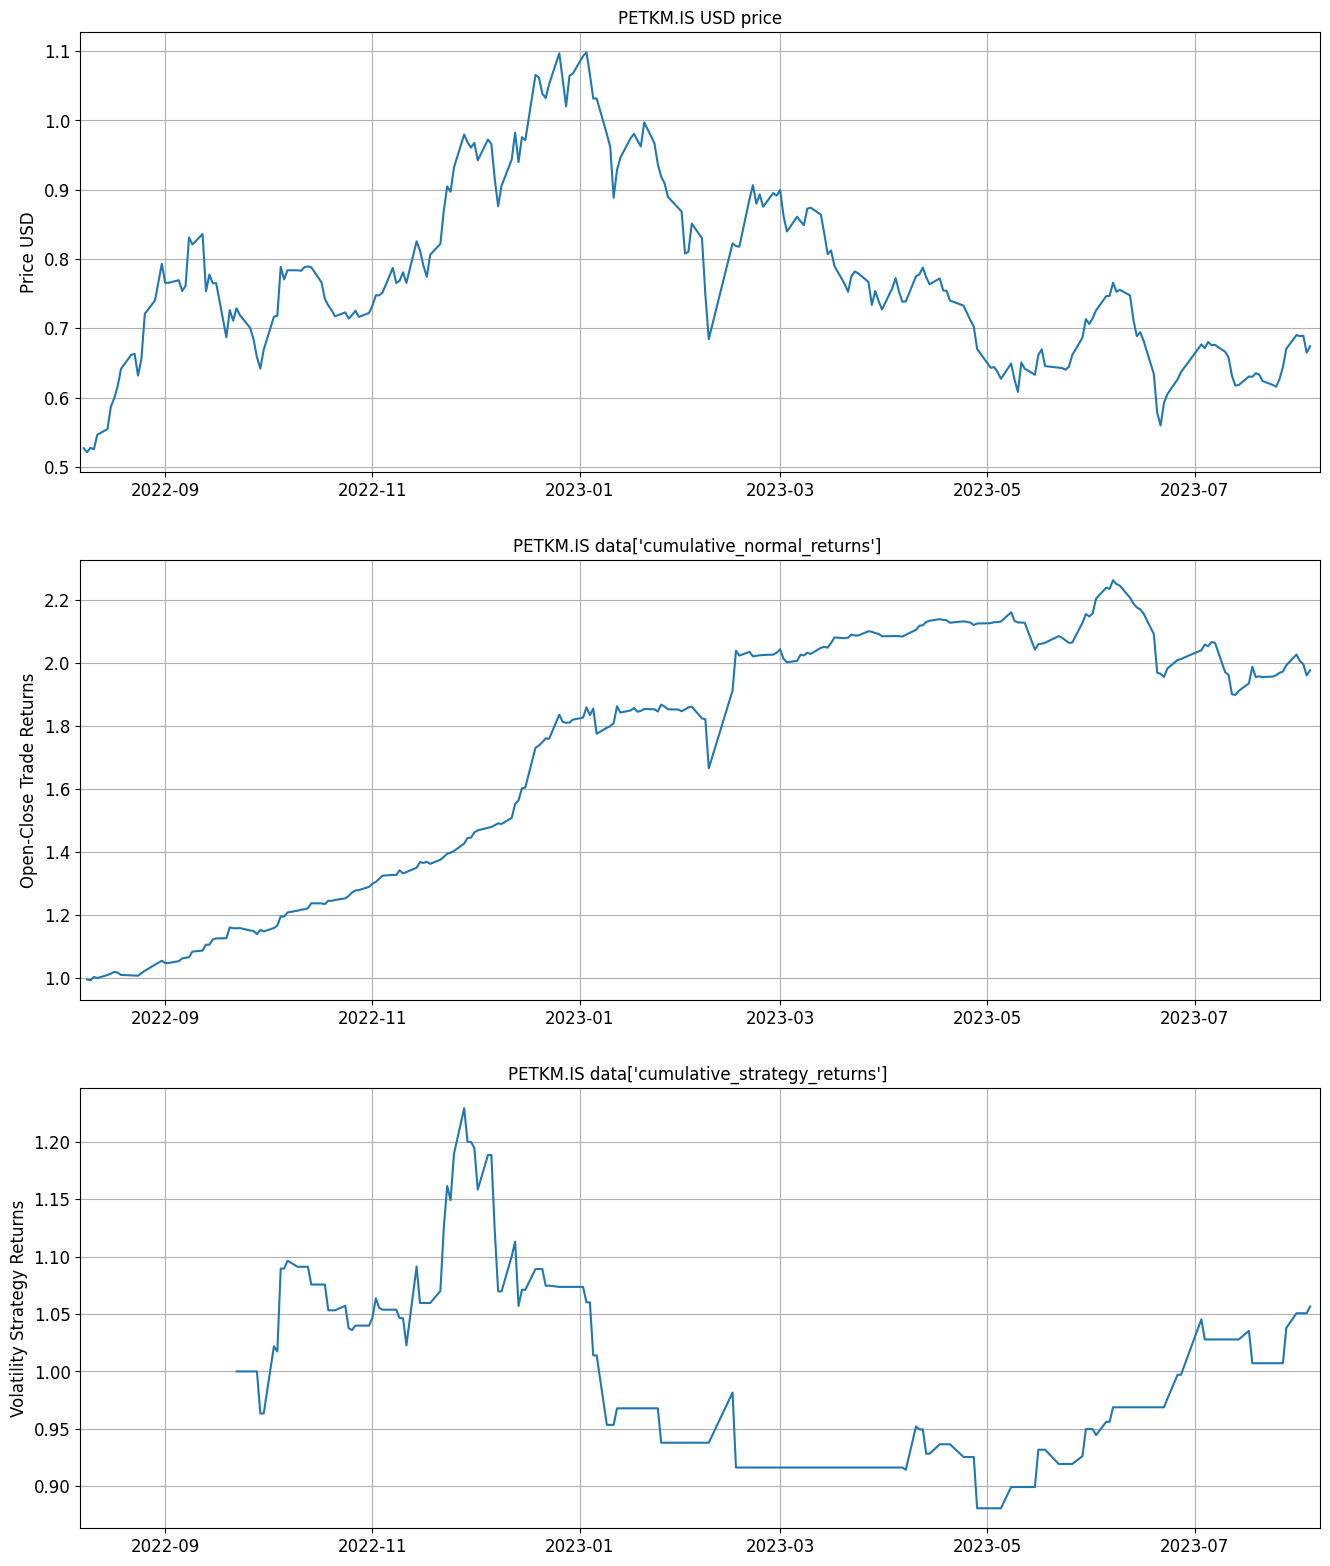


Creating Tear Sheet for PETKM.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for PETKM.IS Buy-Hold

State probabilities:
(-inf, 0.0]    0.524194
(0.0, inf]     0.475806
Name: rets, dtype: float64

Next State Probabilities for PETKM.IS Open-Close

State probabilities:
(0.0, inf]     0.616935
(-inf, 0.0]    0.383065
Name: returns, dtype: float64


Showing Ticker Stats for TAVHL.IS : 



Updating data for TAVHL.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for TAVHL.IS

Plotting Open-Close Performance for TAVHL.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


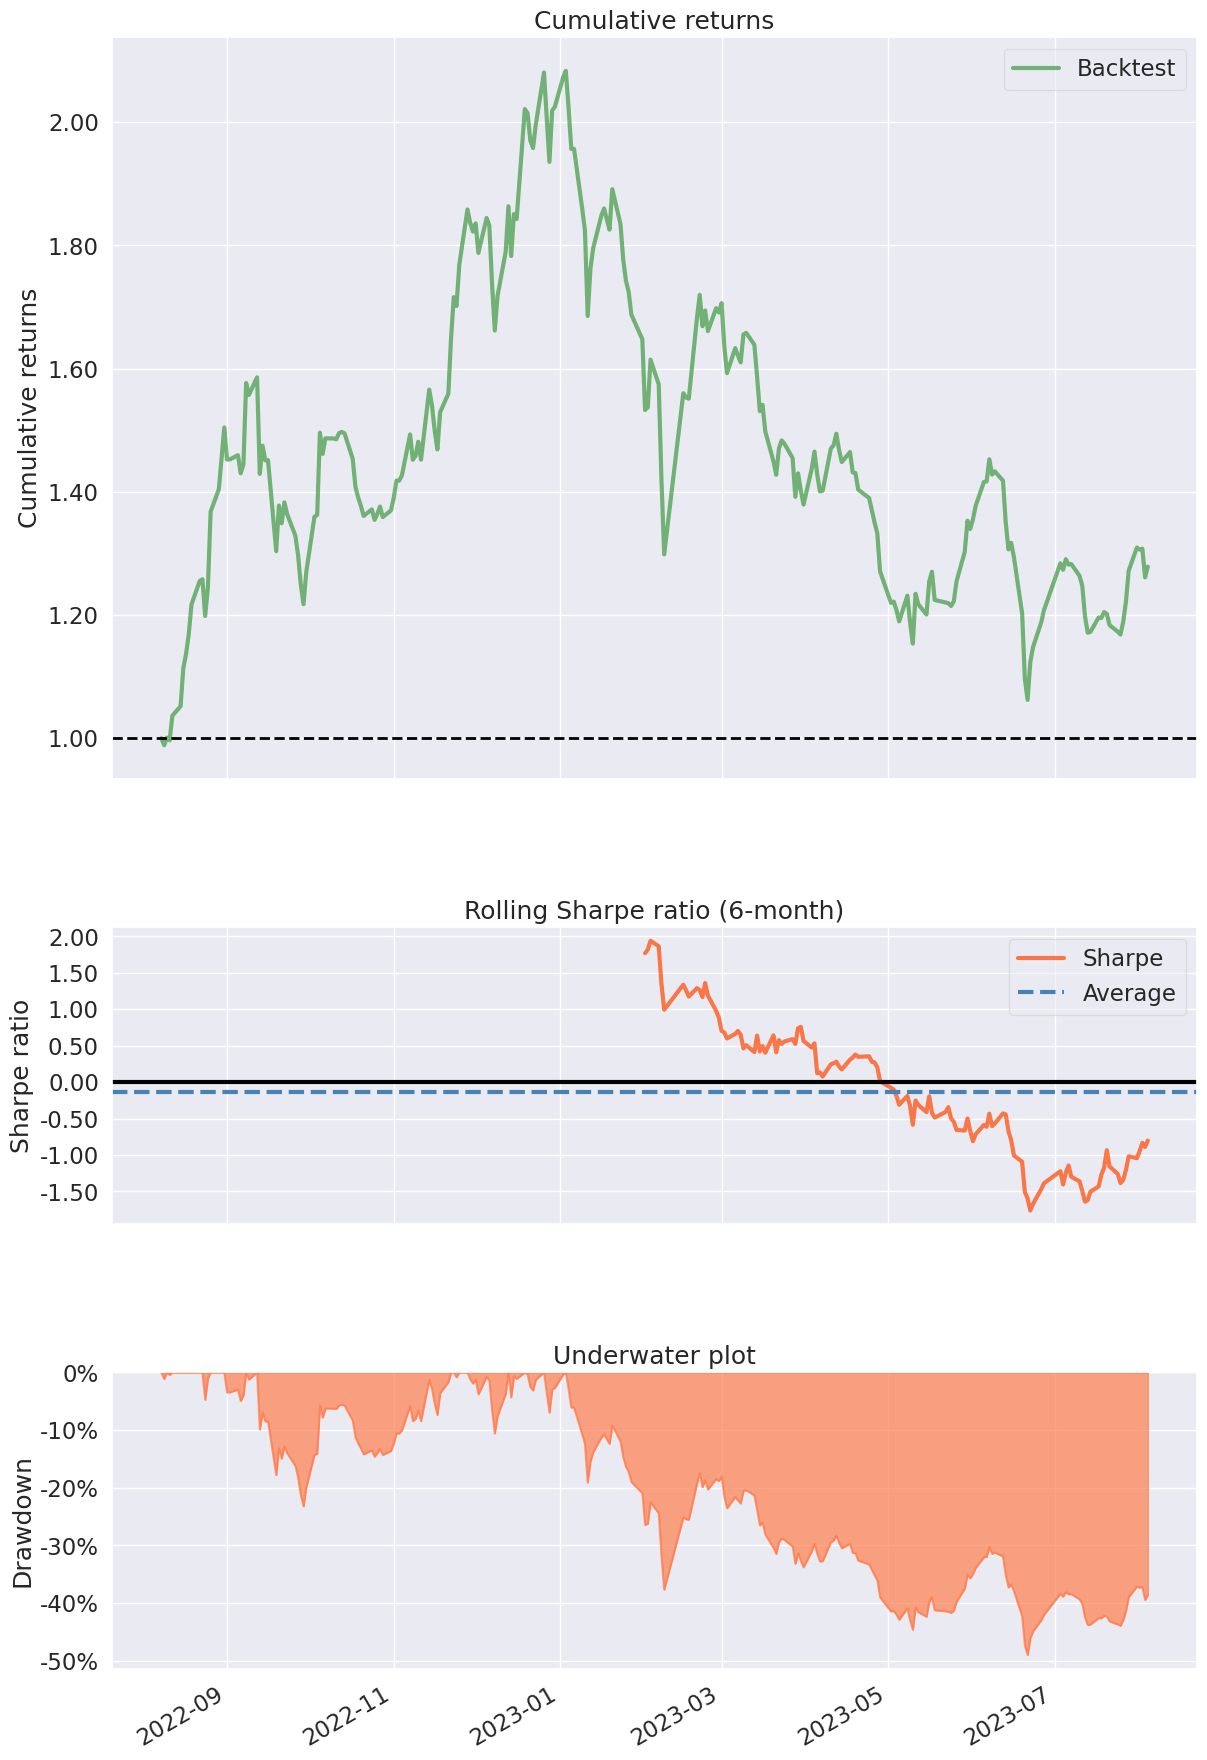

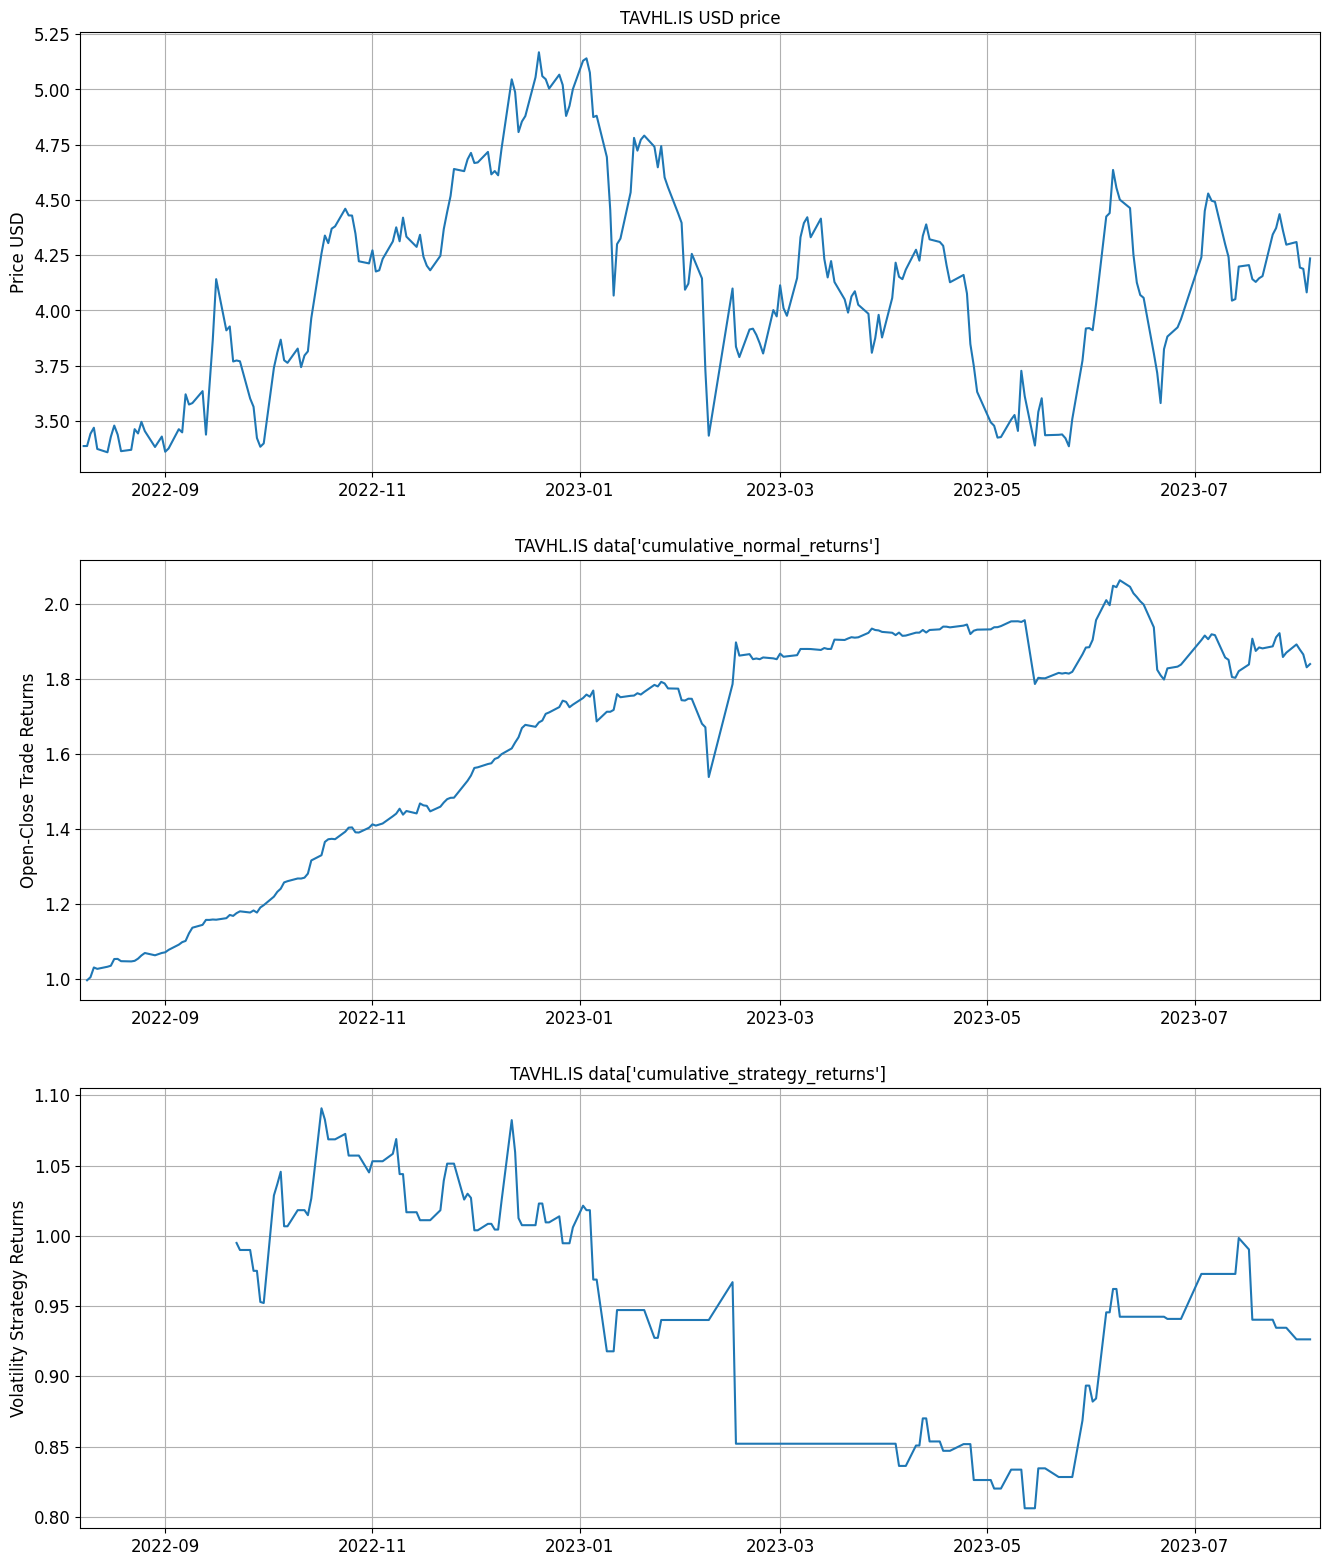


Creating Tear Sheet for TAVHL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for TAVHL.IS Buy-Hold

State probabilities:
(0.0, inf]     0.504032
(-inf, 0.0]    0.495968
Name: rets, dtype: float64

Next State Probabilities for TAVHL.IS Open-Close

State probabilities:
(0.0, inf]     0.641129
(-inf, 0.0]    0.358871
Name: returns, dtype: float64


Showing Ticker Stats for EREGL.IS : 



Updating data for EREGL.IS

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Plotting for EREGL.IS

Plotting Open-Close Performance for EREGL.IS


<ipython-input-224-029e59240b53>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)
<ipython-input-224-029e59240b53>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 2)
<ipython-input-224-029e59240b53>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


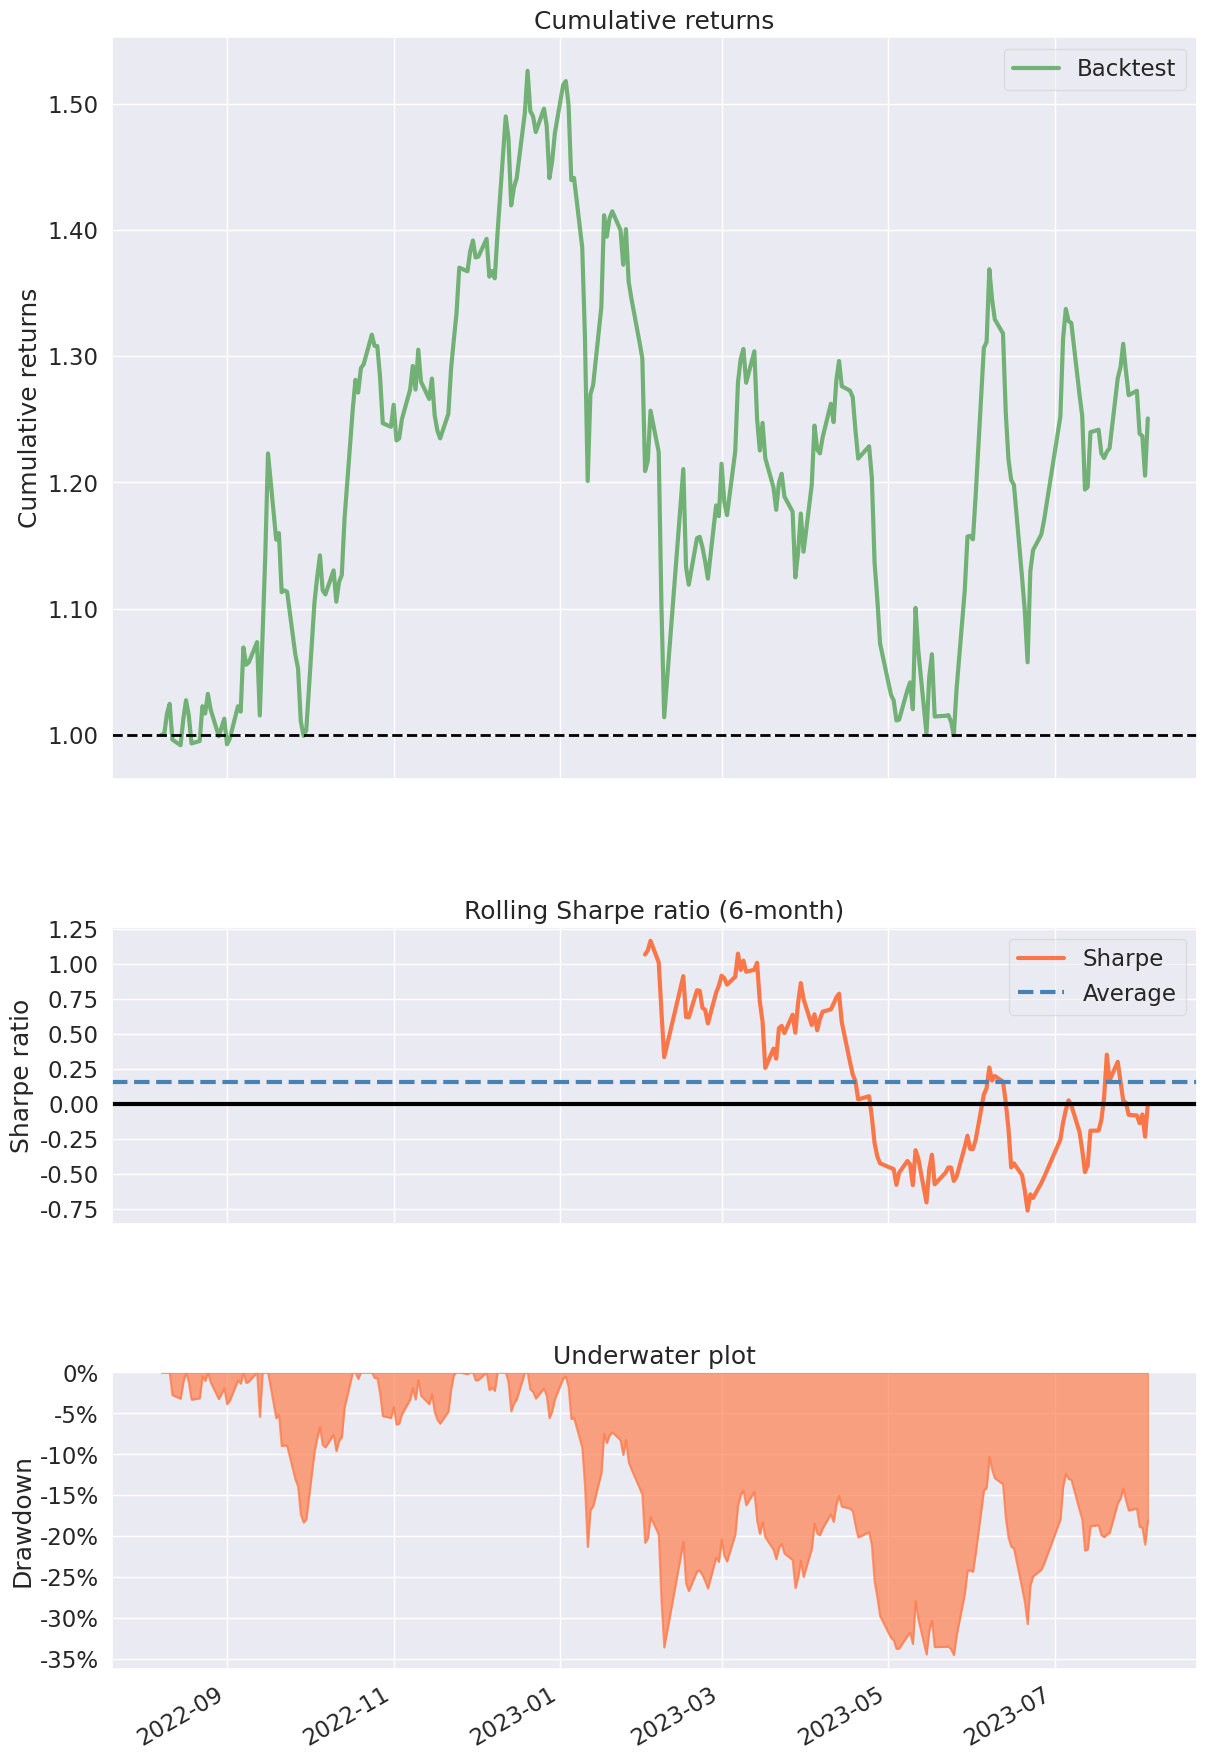

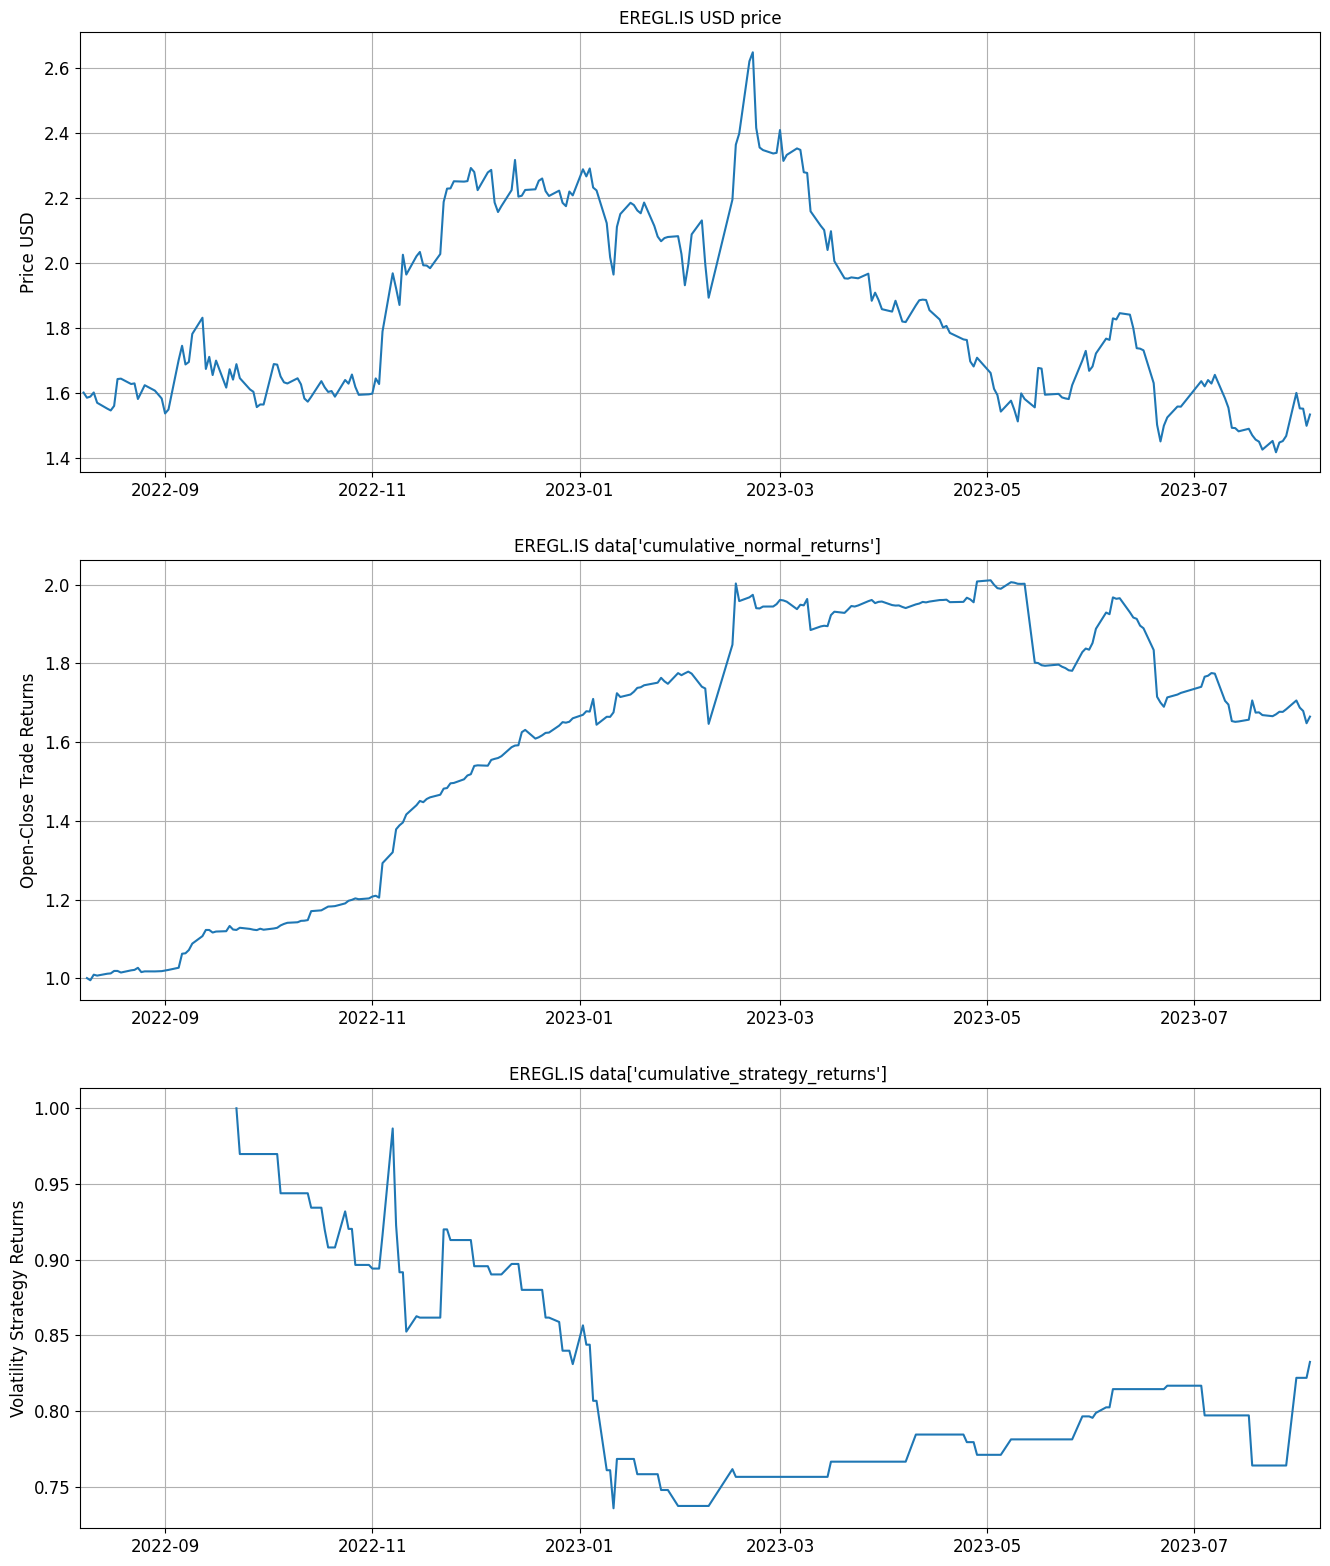


Creating Tear Sheet for EREGL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



Next State Probabilities for EREGL.IS Buy-Hold

State probabilities:
(-inf, 0.0]    0.560484
(0.0, inf]     0.439516
Name: rets, dtype: float64

Next State Probabilities for EREGL.IS Open-Close

State probabilities:
(0.0, inf]     0.645161
(-inf, 0.0]    0.354839
Name: returns, dtype: float64


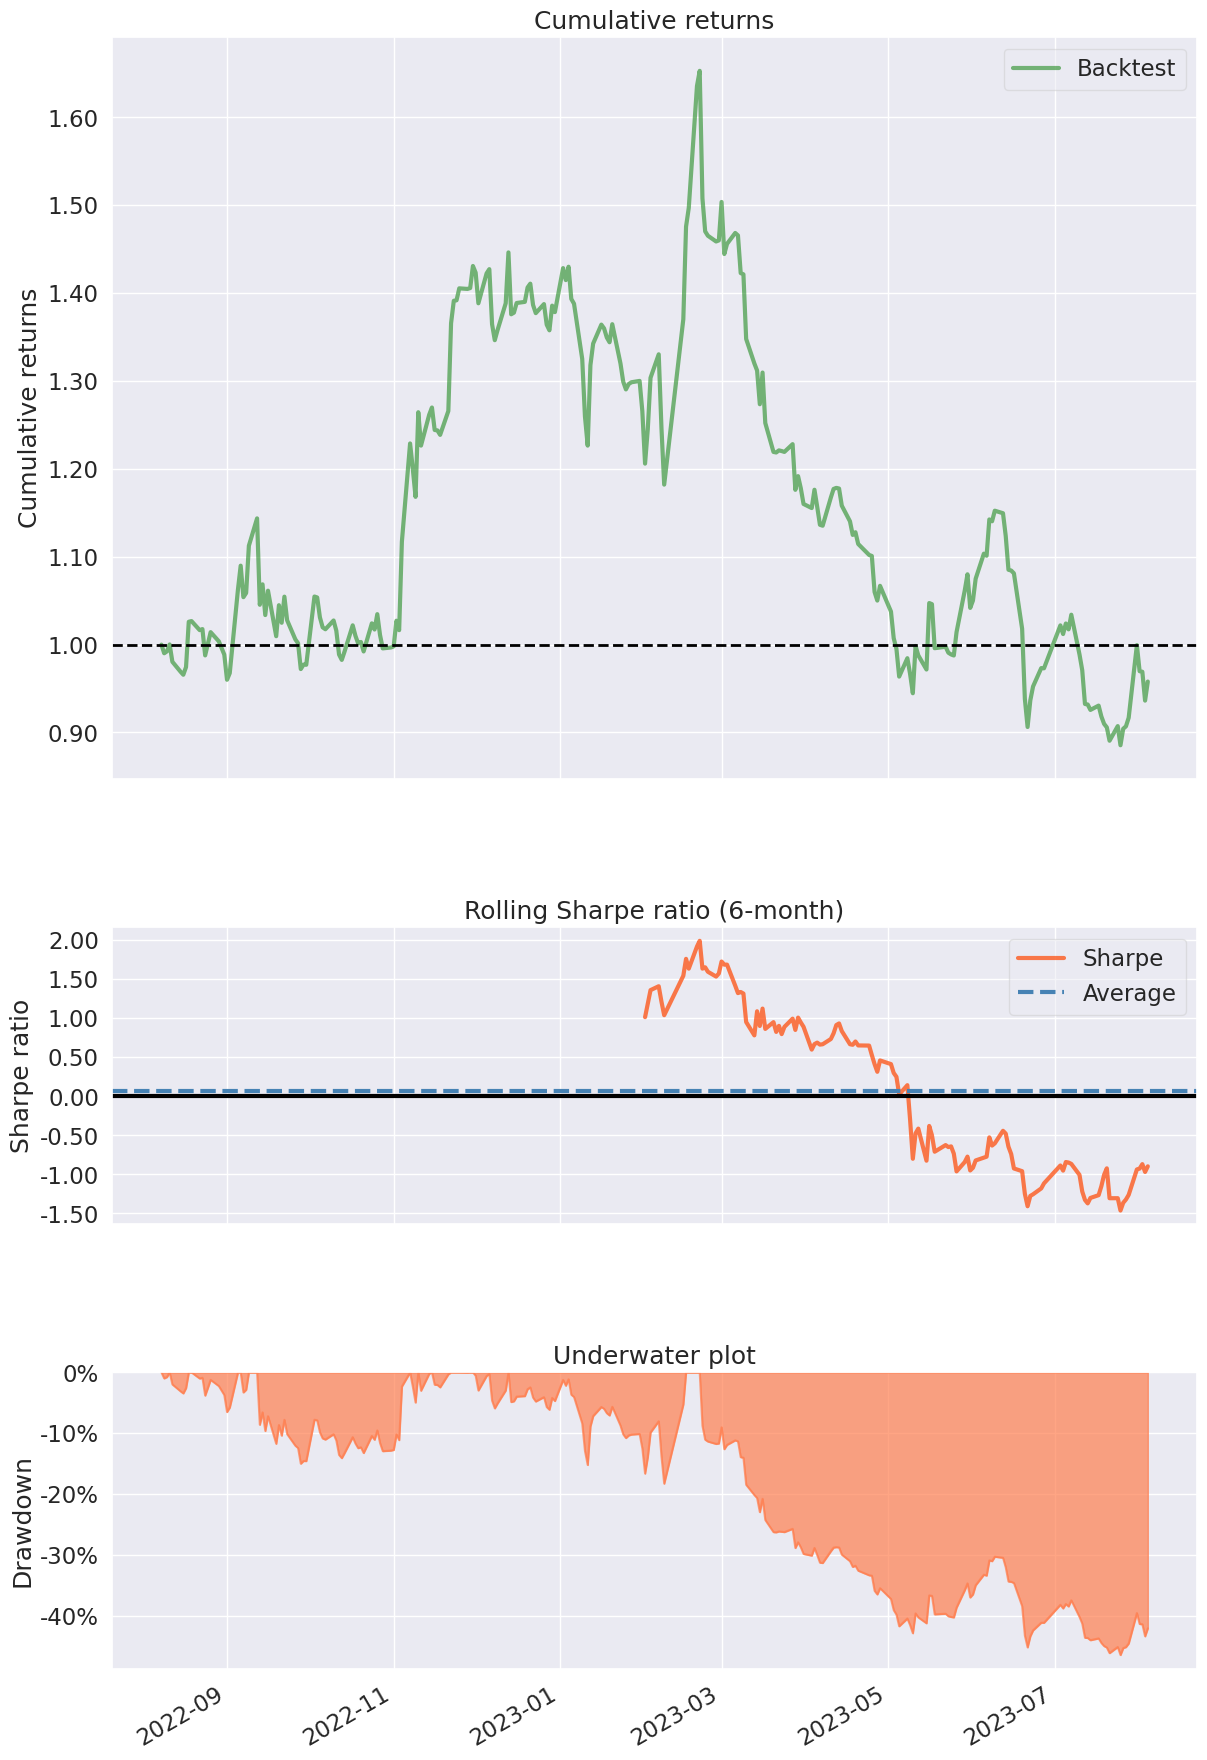

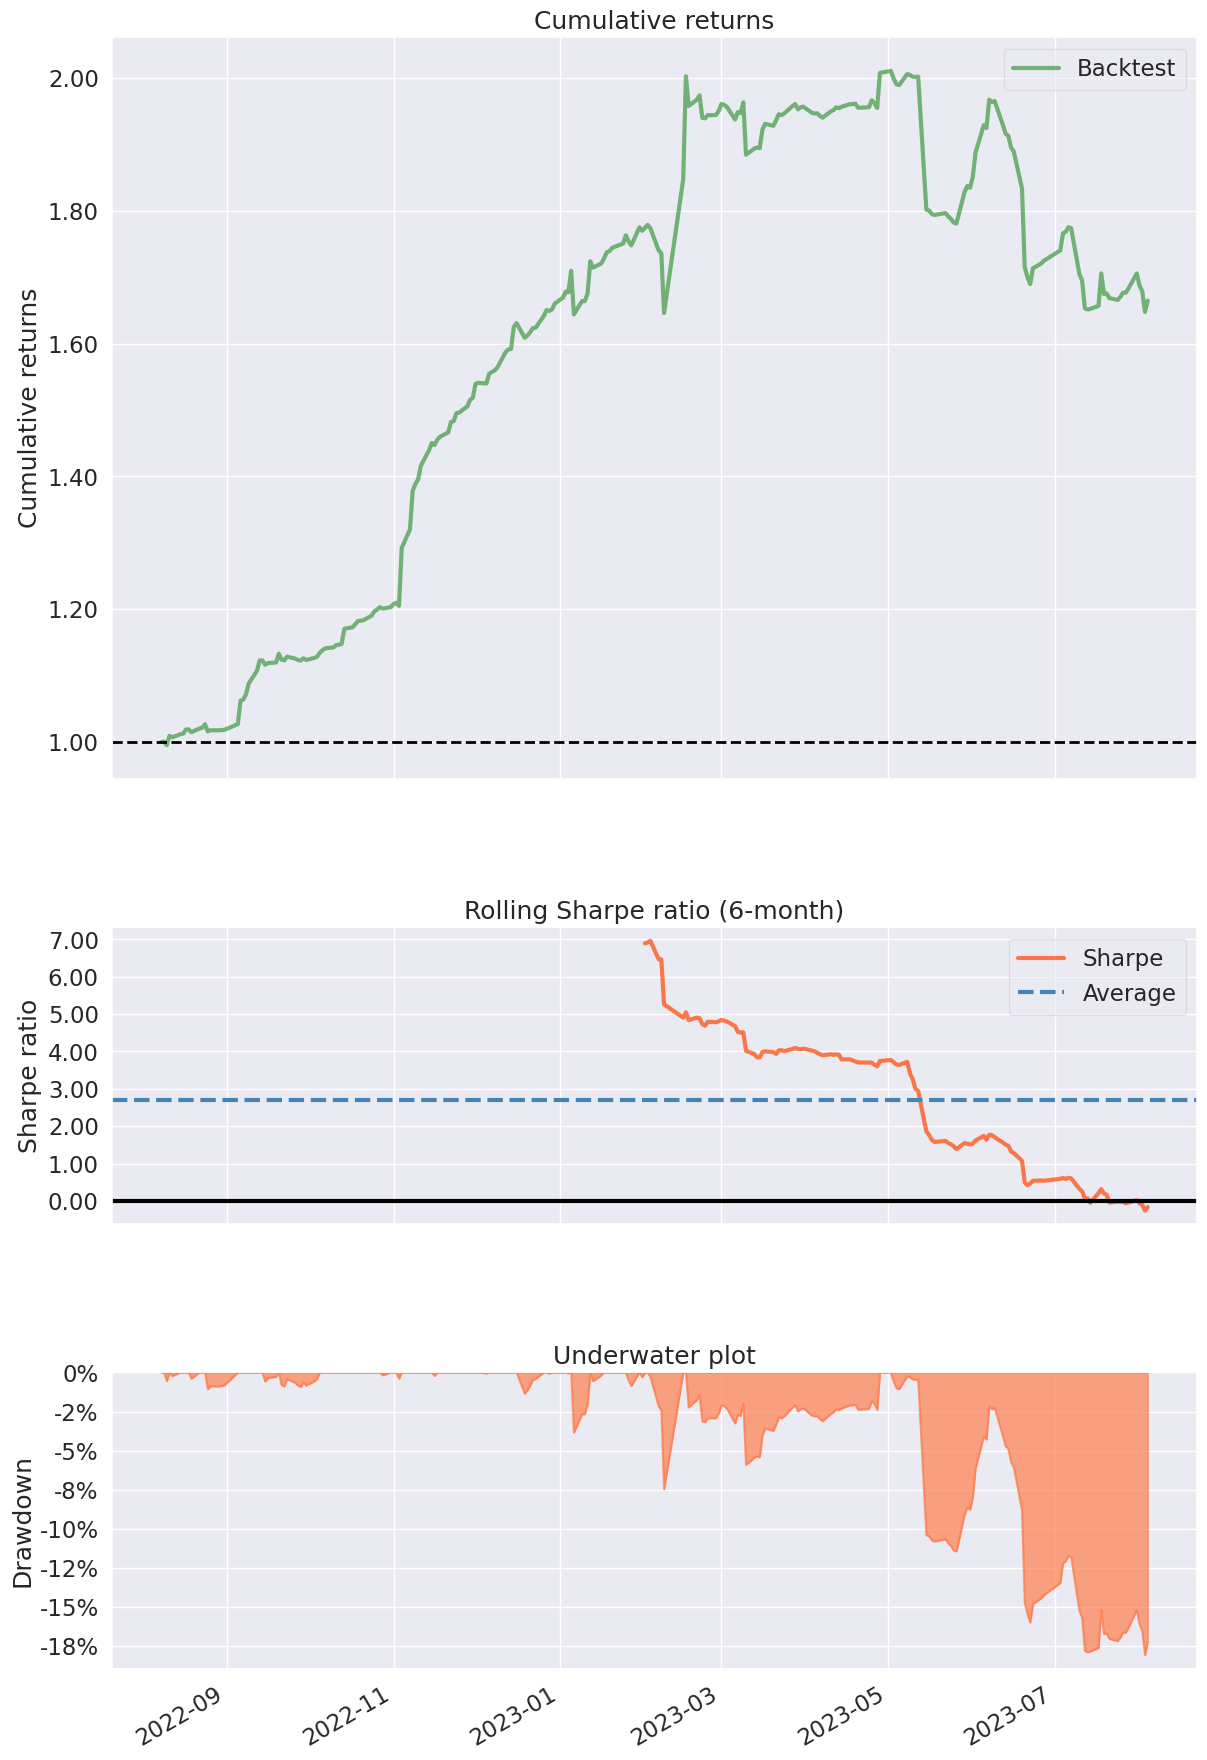

In [235]:
def main():

  bist_df = ShowTRMarket(BIST30)
  for ticker in bist_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"BIST")

  # dow_df = ShowUSMarket(DOW30)
  # sp500_df = ShowUSMarket(sp500_constituents.Symbol)
  # for ticker in dow_df['Ticker']:
  # for ticker in sp500_df['Ticker']:
  #    ShowTickerStats( ticker,"SP500")

  #EmpyrialPortfolioPerformance()

if __name__ == "__main__":
    main()